## 1. Intro  
제공된 이커머스 데이터를 활용해 고객들을 효과적으로 세분화 하고 그들의 행동패턴 혹은 구매경향을 이해하여 더 나은 서비스를 제공할 수 있는 방안 제시를 목적으로 한다.  
이커머스 사업에서 중요한 것 중 하나는 고객이 선호하는 제품에 민감하게 반응하는 것이라 생각한다.    
그러므로 본 분석에서는 RFM 개념을 활용해 고객의 유형을 구분하고 구분된 유형의 유저의 구매 아이템을 기준으로 특징을 파악, 인사이트를 도출하는 것을 목표로 한다.  


## 2. Data Loading

In [1]:
import pandas as pd

sales = pd.read_csv('./dataset/Onlinesales_info.csv')
customers= pd.read_csv('./dataset/Customer_info.csv')
coupon = pd.read_csv('./dataset/Discount_info.csv')
marketing = pd.read_csv('./dataset/Marketing_info.csv')
tax = pd.read_csv('./dataset/Tax_info.csv')

## 3. Data Check & Cleaning  
데이콘 제공데이터로, Null값이 존재하지 않고 sales 및 customer data 간 key id list가 일치한다.  
coupon의 경우 '월' 정보가 영문축약형으로 되어있어 해당 부분을 타 데이터의 형식에 맞게 변경한다.  
  
각 데이터에 대한 정보는 다음과 같다.  
  
online_sales : 고객 거래데이터로 거래날짜, 금액, 수량 등 거래관련 정보

customers_data : 고객 데이터로 성별, 거주지, 가입기간 정보

discount_coupon : 월별 제품 카테고리에 적용된 쿠폰에 대한 정보

marketing_spend : 월별 마케팅 비용

tax_amount : 제품 카테고리별 적용 세금


In [2]:
display(sales.info())
display(customers.info())
display(coupon.info())
display(marketing.info())
display(tax.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   고객ID    52924 non-null  object 
 1   거래ID    52924 non-null  object 
 2   거래날짜    52924 non-null  object 
 3   제품ID    52924 non-null  object 
 4   제품카테고리  52924 non-null  object 
 5   수량      52924 non-null  int64  
 6   평균금액    52924 non-null  float64
 7   배송료     52924 non-null  float64
 8   쿠폰상태    52924 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   고객ID    1468 non-null   object
 1   성별      1468 non-null   object
 2   고객지역    1468 non-null   object
 3   가입기간    1468 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 46.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   월       204 non-null    object
 1   제품카테고리  204 non-null    object
 2   쿠폰코드    204 non-null    object
 3   할인율     204 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      365 non-null    object 
 1   오프라인비용  365 non-null    int64  
 2   온라인비용   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   제품카테고리  20 non-null     object 
 1   GST     20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes


None

In [3]:
if customers.고객ID.nunique() == sales.고객ID.nunique():
    print('online_sale, customer_data 고객 id의 정합성이 지켜져있습니다.')

online_sale, customer_data 고객 id의 정합성이 지켜져있습니다.


In [4]:
def transform_month(month):
    month_mapping = {
        'Jan': '2019-01',
        'Feb': '2019-02',
        'Mar': '2019-03',
        'Apr': '2019-04',
        'May': '2019-05',
        'Jun': '2019-06',
        'Jul': '2019-07',
        'Aug': '2019-08',
        'Sep': '2019-09',
        'Oct': '2019-10',
        'Nov': '2019-11',
        'Dec': '2019-12'
    }
    
    return month_mapping[month]

coupon['월'] = coupon['월'].map(transform_month)
coupon.sample(3)

,월,제품카테고리,쿠폰코드,할인율
41,2019-03,Accessories,ACC30,30
155,2019-12,Apparel,SALE30,30
53,2019-06,Apparel,SALE30,30


## 4. EDA  
각 table을 파악함으로써 의문점을 도출하거나 파악해볼 수 있는 과제를 도출한다. 


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_palette('pastel')
matplotlib.rcParams['axes.unicode_minus'] = False
plt.rc('font',  family='malgun gothic')

### 1. Sales 데이터 확인

전체적으로 9월이 유저 및 거래 수가 급감하는 달임을 알 수 있다.  

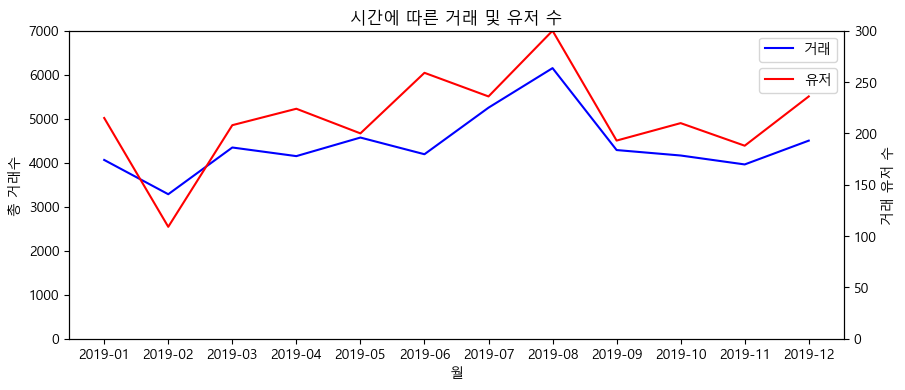

In [5]:
trans_counts_by_month =sales.assign(Month = pd.to_datetime(sales['거래날짜']).dt.to_period('M')).groupby('Month')['거래ID'].count().sort_index()
user_counts_by_month = sales.assign(Month = pd.to_datetime(sales['거래날짜']).dt.to_period('M')).groupby('Month')['고객ID'].nunique()

fig, ax1 = plt.subplots(figsize = (10, 4))

ax2 = ax1.twinx()

g1 = sns.lineplot( x = trans_counts_by_month.index.astype(str), y = trans_counts_by_month.values, color = 'blue', ax = ax1)
ax1.set_ylabel('총 거래수')
ax1.set_ylim(0, 7000)

g2 = sns.lineplot( x = user_counts_by_month.index.astype(str), y = user_counts_by_month.values, color = 'red', ax = ax2)
ax2.set_ylabel('거래 유저 수')
ax2.set_ylim(0, 300)
ax1.legend(['거래'], loc = 'upper right')
ax2.legend(['유저'], bbox_to_anchor = (1,0.9))

ax1.set_xlabel('월')

plt.title('시간에 따른 거래 및 유저 수')
plt.show()

거래금액의 경우 9월 이후 확실한 증가세를 보이고 있다.  
9월 이후 주춤하고 있는 유저 수 및 거래 수 와는 다른 양상을 보이고 있으며 한번의 거래에 비싸거나 많은 품목이 거래되고 있음을 짐작할 수 있다.

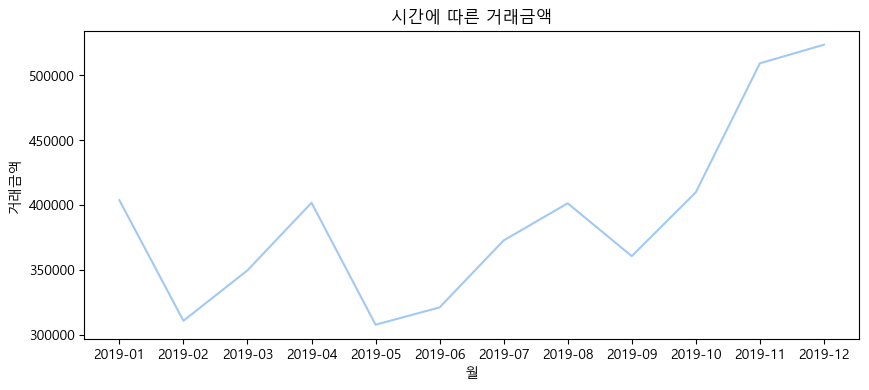

In [6]:
total_price_by_month = sales.assign(Month = pd.to_datetime(sales['거래날짜']).dt.to_period('M'), 
                    total_price = sales['수량'] * sales['평균금액']).groupby('Month')['total_price'].sum()

plt.figure(figsize = (10, 4))
sns.lineplot( x = total_price_by_month.index.astype(str),
              y = total_price_by_month.values)
plt.title('시간에 따른 거래금액')
plt.xlabel('월')
plt.ylabel('거래금액')
# plt.xticks(rotation = 45)
plt.show()

제품 카테고리별 판매량을 봤을 때 office 및 apparel과 같은 제품이 많이 판매된다.

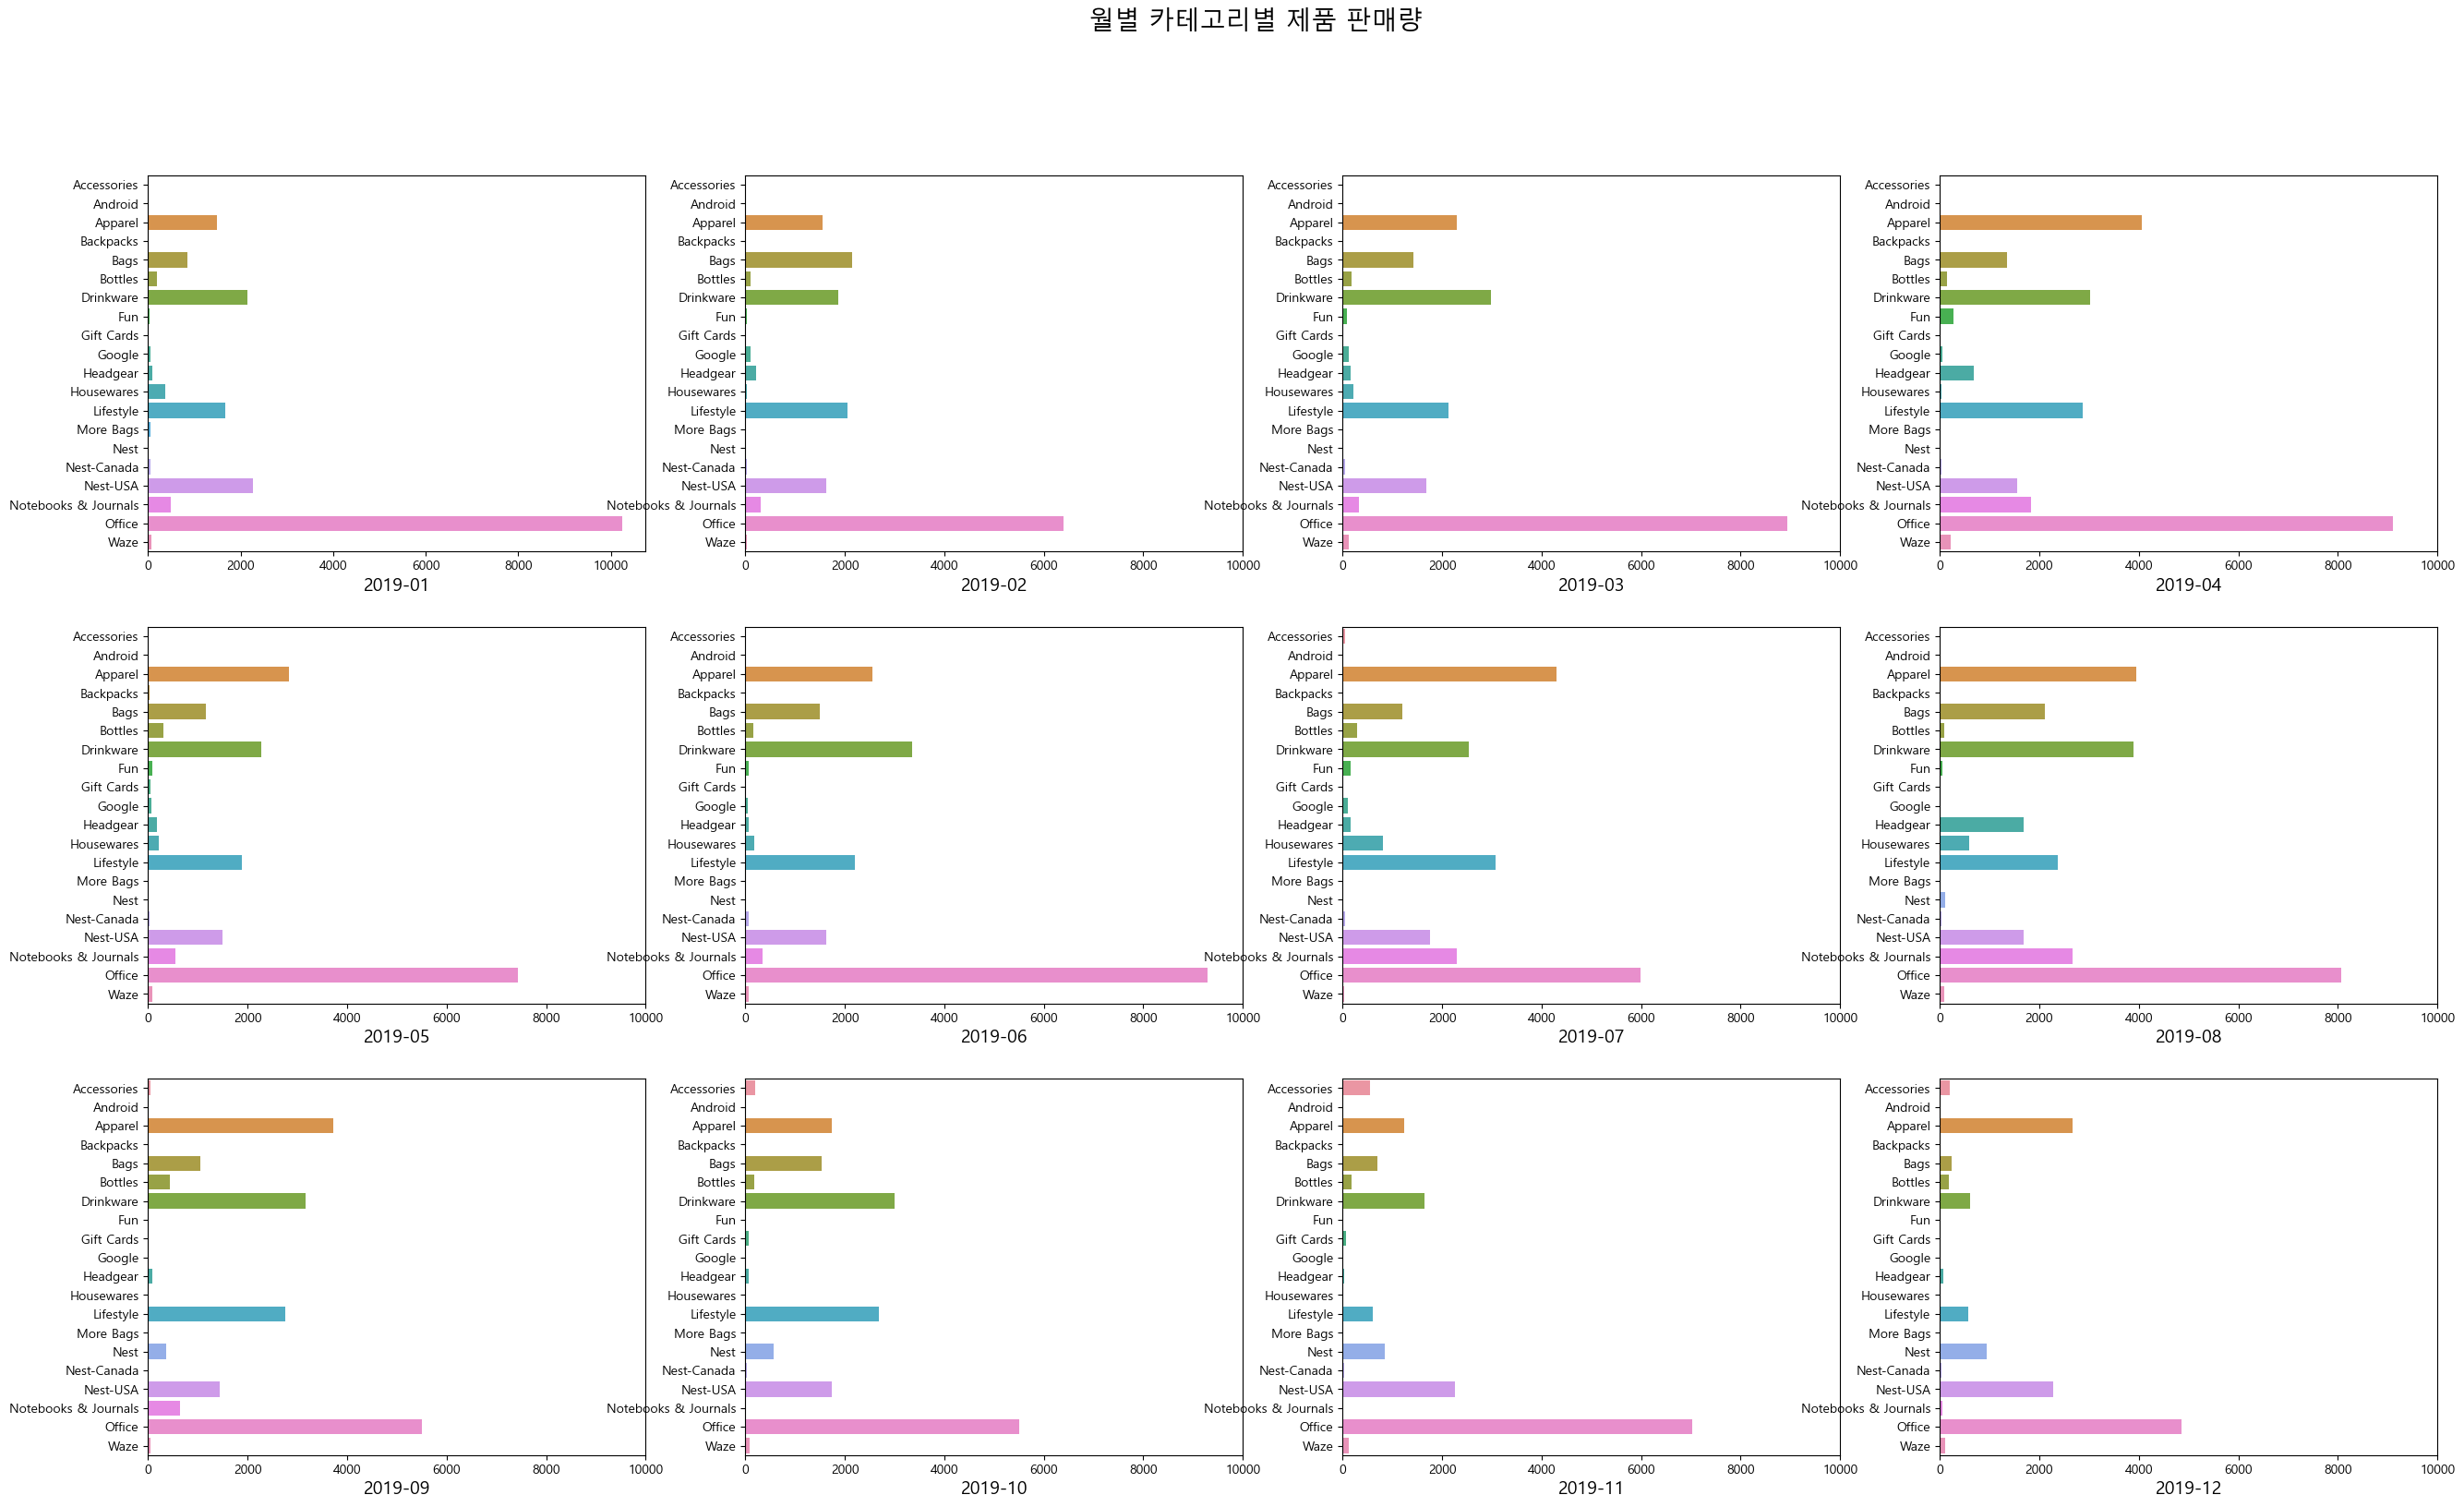

In [7]:
count_cat_by_month = sales.assign(Month = pd.to_datetime(sales['거래날짜']).dt.to_period('M')).groupby(['Month','제품카테고리'])[['수량']].sum().reset_index()
cat_dict = { k : 0 for k in sorted(sales.제품카테고리.unique())}
periods = pd.period_range(start='2019-01', end='2019-12', freq='M')
fig, ax = plt.subplots( nrows = 3, ncols = 4, figsize = (32, 18))

for i in range(12):
    r, c = i//4, i%4
    p = periods[i]
    
    cat_dict.update(count_cat_by_month.query(f'`Month` == @p')[['제품카테고리', '수량']].set_index('제품카테고리').squeeze())
    new_df = pd.DataFrame(cat_dict.values(), cat_dict.keys(), columns = ['수량'])
    
    sns.barplot(data = new_df, x = '수량', y = new_df.index, ax = ax[r][c])
    ax[r][c].set_xticks(range(0,10001, 2000))
    ax[r][c].set_xlabel(p, fontsize = 14)
    ax[r][c].set_ylabel('')
plt.suptitle('월별 카테고리별 제품 판매량', fontsize = 20)
plt.show()

반면 제품 매출의 경우 Nest-USA가 대부분을 차지함을 볼 수 있다.

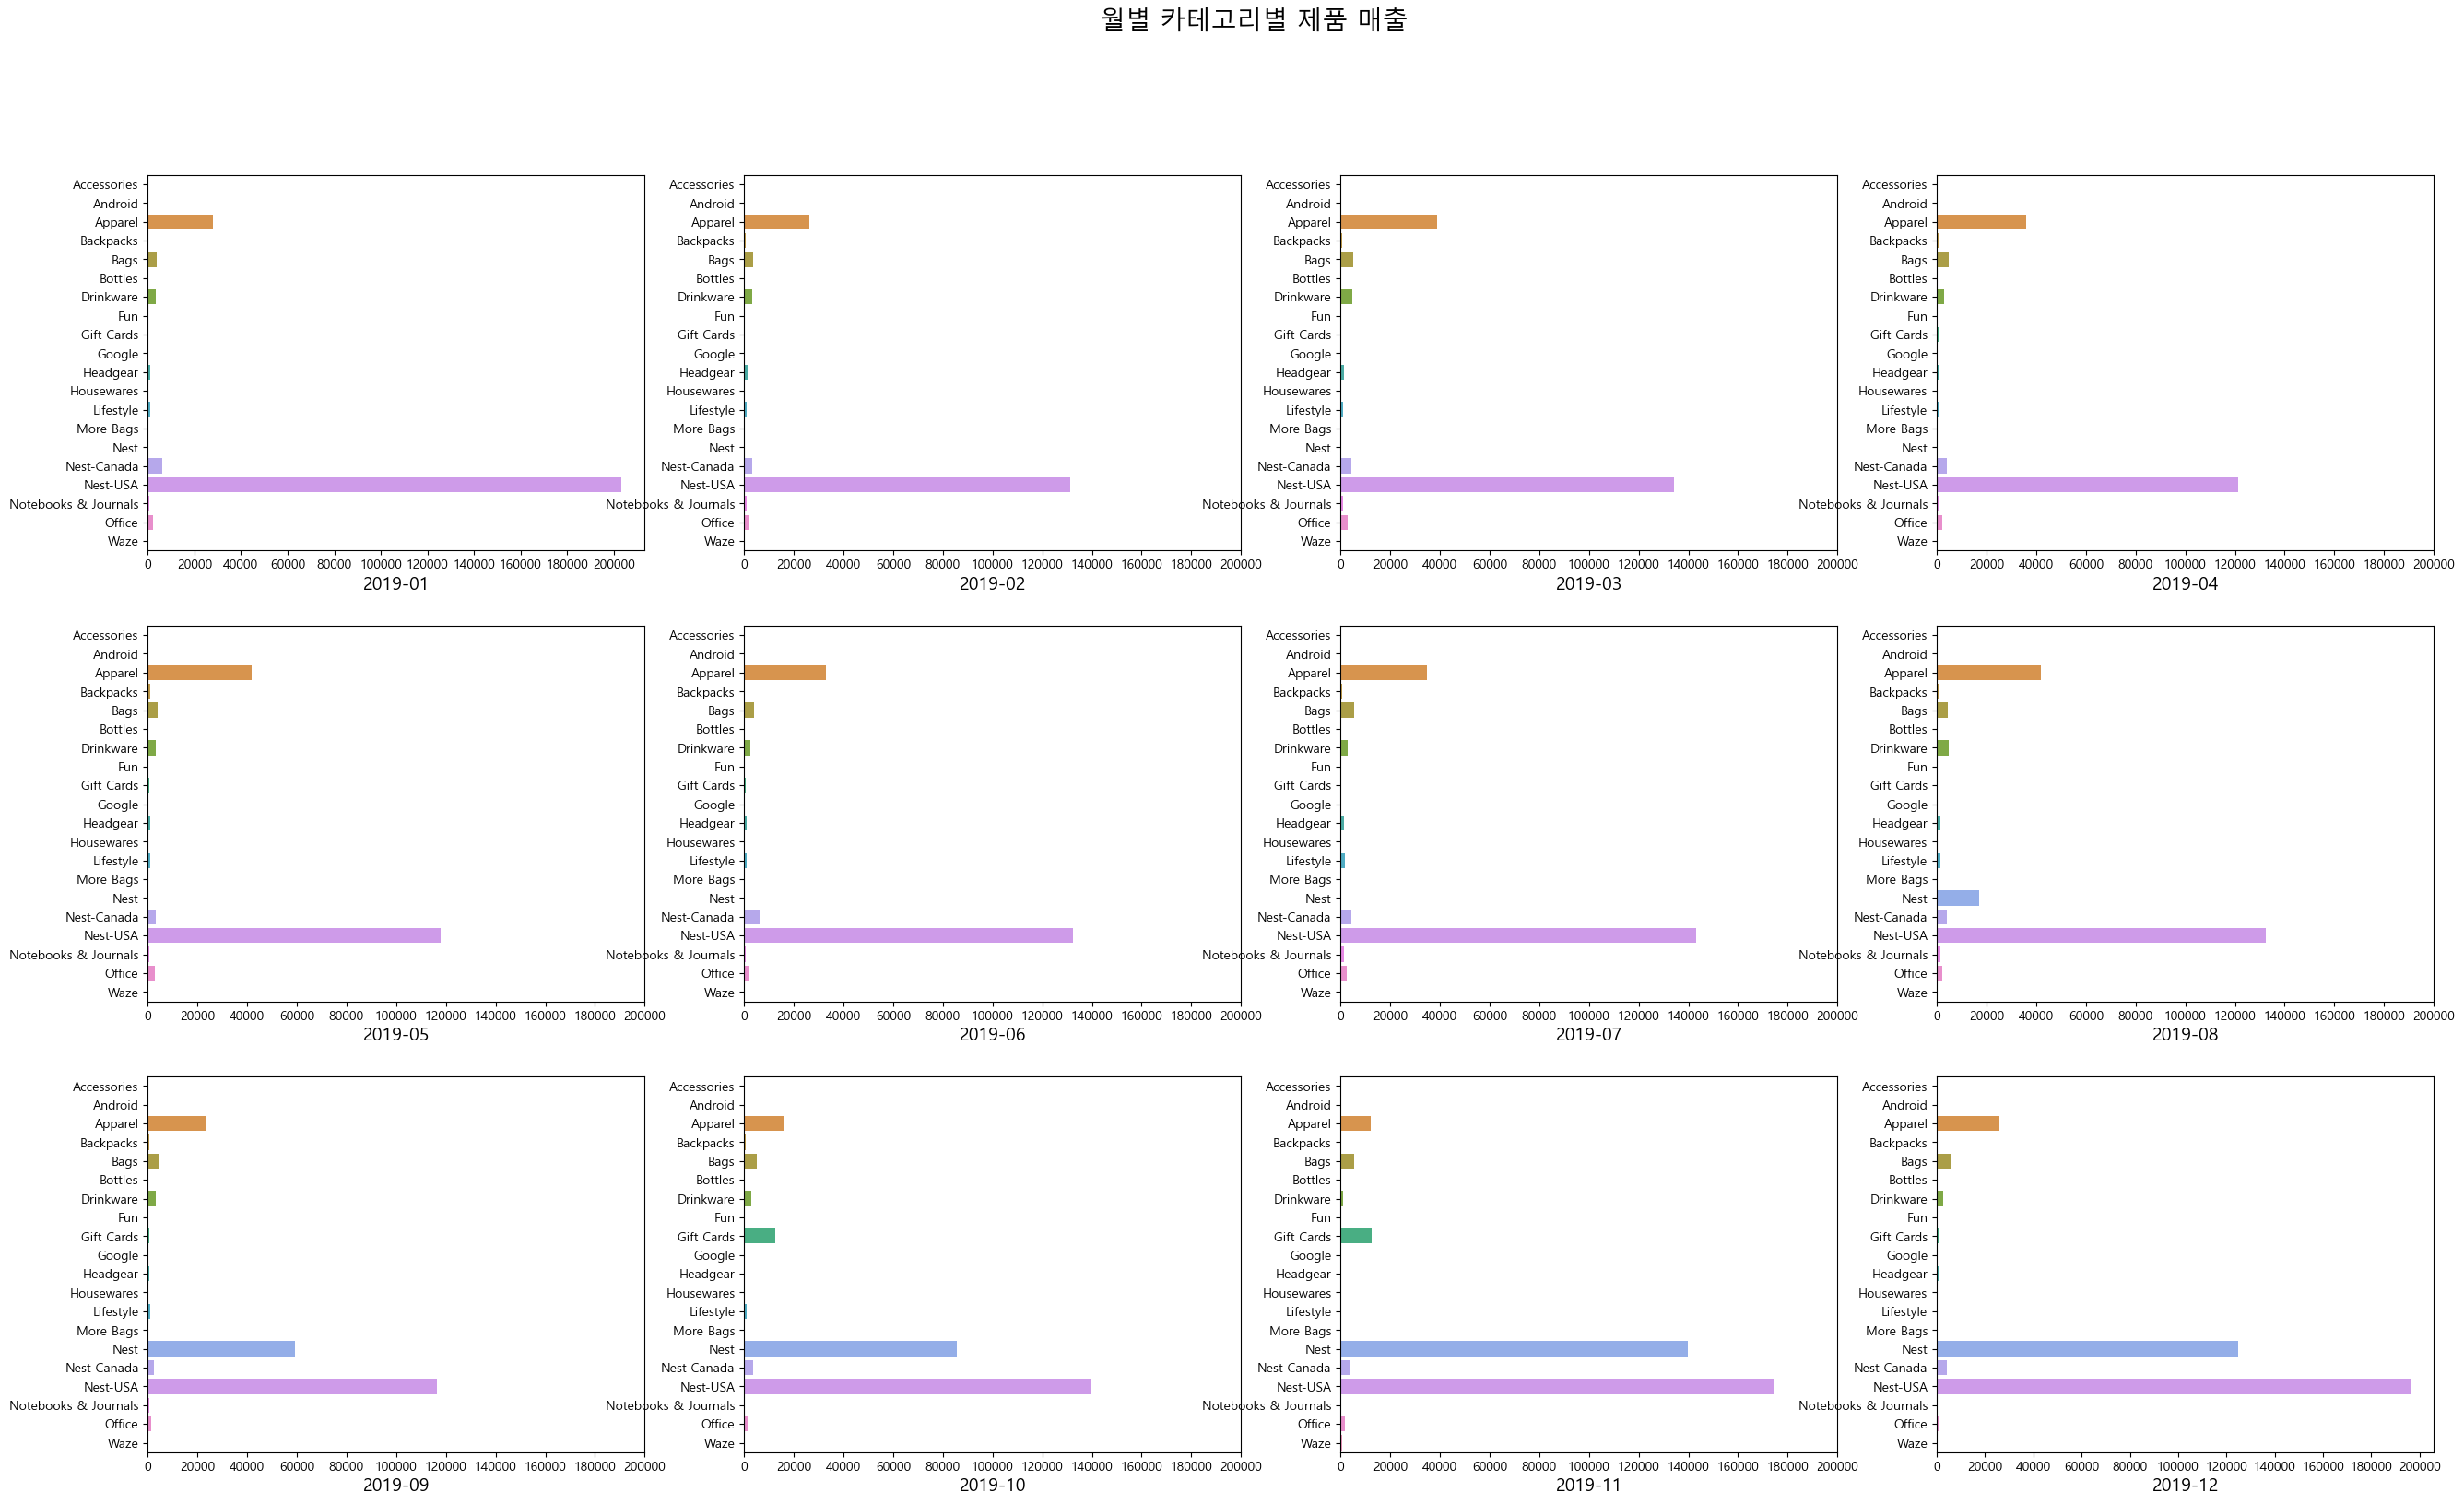

In [8]:
sales_cat_by_month = sales.assign(total_price = sales['수량'] * sales['평균금액'], Month = pd.to_datetime(sales['거래날짜']).dt.to_period('M')).groupby(['Month','제품카테고리'])[['평균금액']].sum().reset_index()
cat_dict = { k : 0 for k in sorted(sales.제품카테고리.unique())}
periods = pd.period_range(start='2019-01', end='2019-12', freq='M')
fig, ax = plt.subplots( nrows = 3, ncols = 4, figsize = (32, 18))

for i in range(12):
    r, c = i//4, i%4
    p = periods[i]
    
    cat_dict.update(sales_cat_by_month.query(f'`Month` == @p')[['제품카테고리', '평균금액']].set_index('제품카테고리').squeeze())
    new_df = pd.DataFrame(cat_dict.values(), cat_dict.keys(), columns = ['평균금액'])
    
    sns.barplot(data = new_df, x = '평균금액', y = new_df.index, ax = ax[r][c])
    ax[r][c].set_xticks(range(0, round(sales_cat_by_month['평균금액'].max()), 20000))
    ax[r][c].set_xlabel(p, fontsize = 14)
    ax[r][c].set_ylabel('')
plt.suptitle('월별 카테고리별 제품 매출', fontsize = 20)
plt.show()

Tree map을 통해 위 내용을 간결히 정리한다.  
먼저, 구체적인 거래가를 계산해 정확한 매출을 계산하도록 한다. 평균가격을 활용한 실거래가의 정의는 다음과 같이 한다.  
    
거래가 = 평균가격 x (1/(1 - 쿠폰할인률)) x (1 + 세율)  

만약 쿠폰사용이 되지 않았다면,  
거래가 = 평균가격 x (1 + 세율)  

In [9]:
import numpy as np

# sales data의 copy본 생성
df = sales.copy()

df['월'] = df.거래날짜.str[:7]
df = df.merge(coupon, on = ['월', '제품카테고리'], how = 'left').merge(tax, on = '제품카테고리', how = 'left')
df['거래가'] = np.where(df.쿠폰상태 =='Used', df.평균금액 * (100/(100 - df.할인율)) * (1+df.GST), df.평균금액 * (1+df.GST))


In [10]:
price_sum = df.loc[:, ['제품카테고리', '수량', '거래가']].groupby('제품카테고리').sum()
price_sum = pd.concat([price_sum, price_sum/price_sum.sum()], axis = 1)
price_sum.columns = ['판매수량', '판매금액', '판매수량_비율', '판매금액_비율']
price_sum.reset_index(inplace = True)

Nest-USA가 전체의 60%이상 판매금액을 차지할 정도로 큰 비중을 차지함

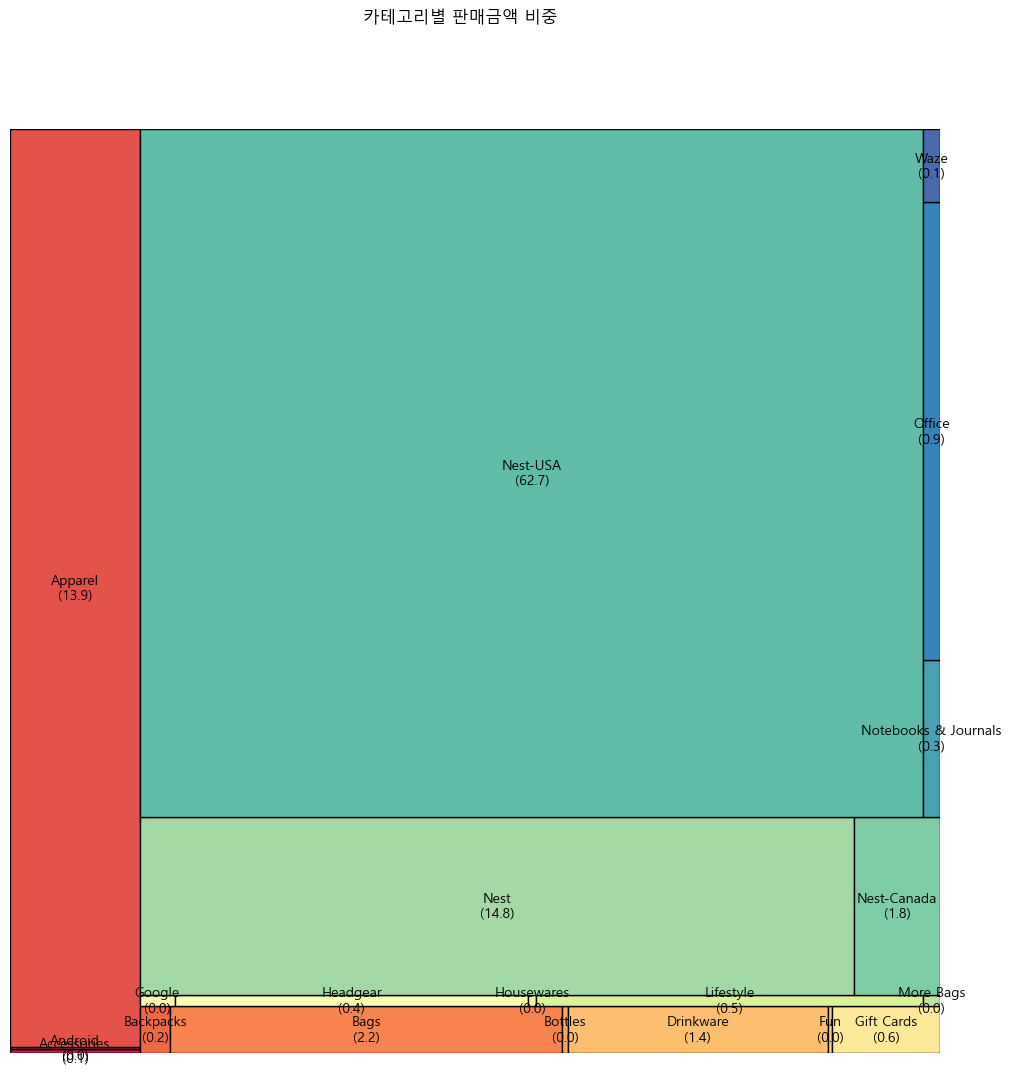

In [11]:
import squarify

plt.figure(figsize = (12, 12))
label = price_sum.제품카테고리 + '\n(' + round(price_sum.판매금액_비율 * 100, 1).astype(str) + ')'
squarify.plot(price_sum.판매금액_비율, label = label, ec = 'black',
              color = sns.color_palette('Spectral', len(price_sum)))
plt.axis('off')
plt.suptitle('카테고리별 판매금액 비중')
plt.show()

Office, Lifestyle, Apparel 등 가격이 낮은 카테고리의 판매수량 비중이 높음

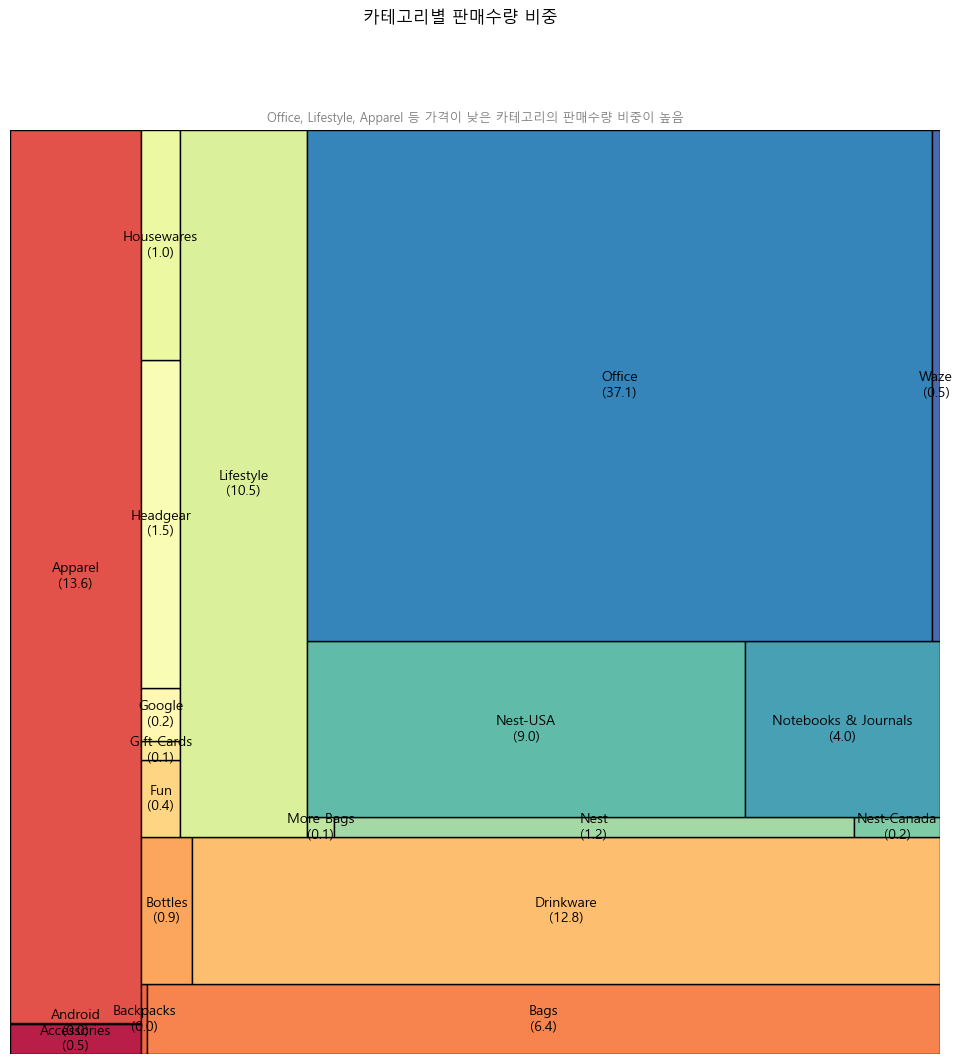

In [12]:
plt.figure(figsize = (12, 12))
label = price_sum.제품카테고리 + '\n(' + round(price_sum.판매수량_비율*100, 1).astype(str) + ')'
squarify.plot(price_sum.판매수량_비율, label=label, ec = 'black',
              color = sns.color_palette("Spectral", len(price_sum)))
plt.axis("off")
plt.suptitle('카테고리별 판매수량 비중')
plt.title('Office, Lifestyle, Apparel 등 가격이 낮은 카테고리의 판매수량 비중이 높음',fontsize=9, color='gray')
plt.show()

위의 결과를 통해 매출의 주 요인인 Nest를 구매한 유저와 그렇지 않은 유저간 특성이 다르지 않을까 하는 의문을 갖게 되었다. Nest 제품은 스마트홈기기류로 제품 구매 주기가 길 것으로 생각이 되기 때문에 리텐션을 통해 두 유저집단간 차이가 있는지를 검증해본다.  

In [13]:
customer_cnt = df.groupby(['월', '제품카테고리']).agg({'고객ID': 'nunique'}).reset_index()
customer_cnt.columns = ['거래월', '제품카테고리', 'cnt']

In [14]:
customer_cnt['전월대비증감률'] = customer_cnt.groupby('제품카테고리')['cnt'].pct_change()*100
customer_cnt['전월대비증감량'] = customer_cnt.groupby('제품카테고리')['cnt'].diff()
customer_cnt.head()

,거래월,제품카테고리,cnt,전월대비증감률,전월대비증감량
0,2019-01,Accessories,1,NaN,NaN
1,2019-01,Android,4,NaN,NaN
2,2019-01,Apparel,164,NaN,NaN
3,2019-01,Backpacks,3,NaN,NaN
4,2019-01,Bags,68,NaN,NaN


전월대비 증감률확인 결과 android와 giftcard의 증가율이 두드러지게 나타난다.  
그러나 증감량에서는 그렇지 못한데, 두 제품 모두 구매수량의 절대치가 매우 낮기 때문에 증가율 부문에서 더 크게 드러나는 것으로 보았다.  
두 그래프를 보았을때 특정 카테고리 아이템들의 증감이 유사한 패턴을 보이는 제품들이 존재한다.  
그러나 증감률의 패턴만 가지고 유사 제품이라 볼 수는 없다.  
따라서 20개의 카테고리 중 유사 제품군 그룹화하여 해당 제품을 구매한 유저들의 특성을 파악해보도록 한다.

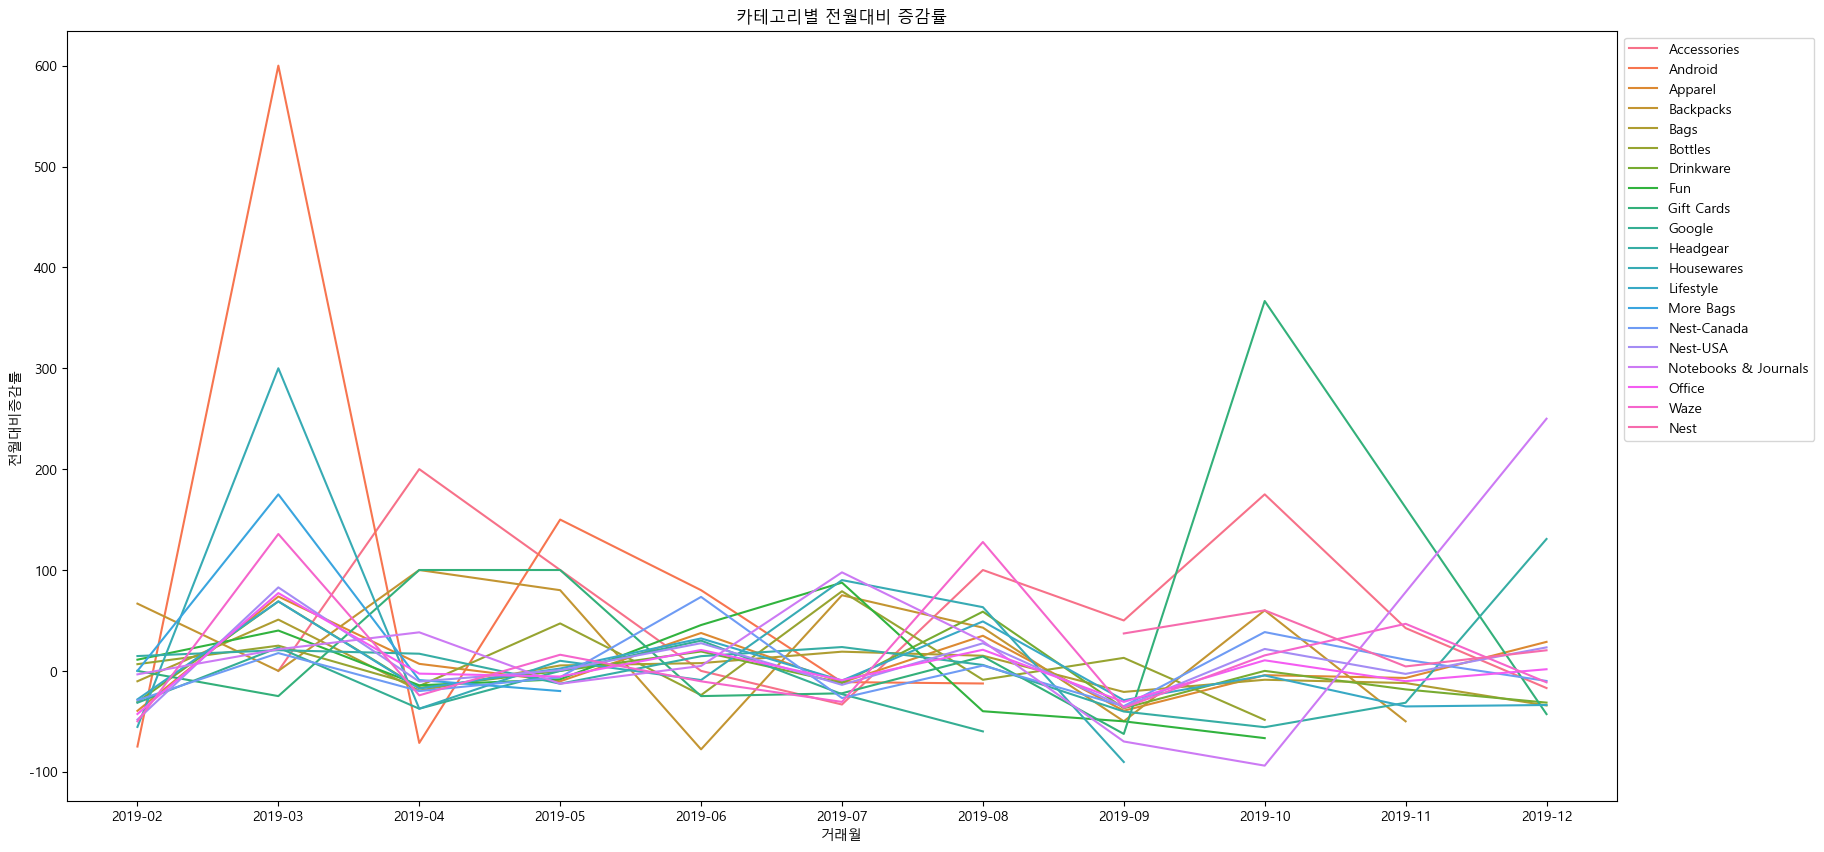

In [15]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = customer_cnt, x = '거래월', y = '전월대비증감률',hue = '제품카테고리')

plt.title('카테고리별 전월대비 증감률')
plt.legend(bbox_to_anchor = (1.0, 1))
plt.show()


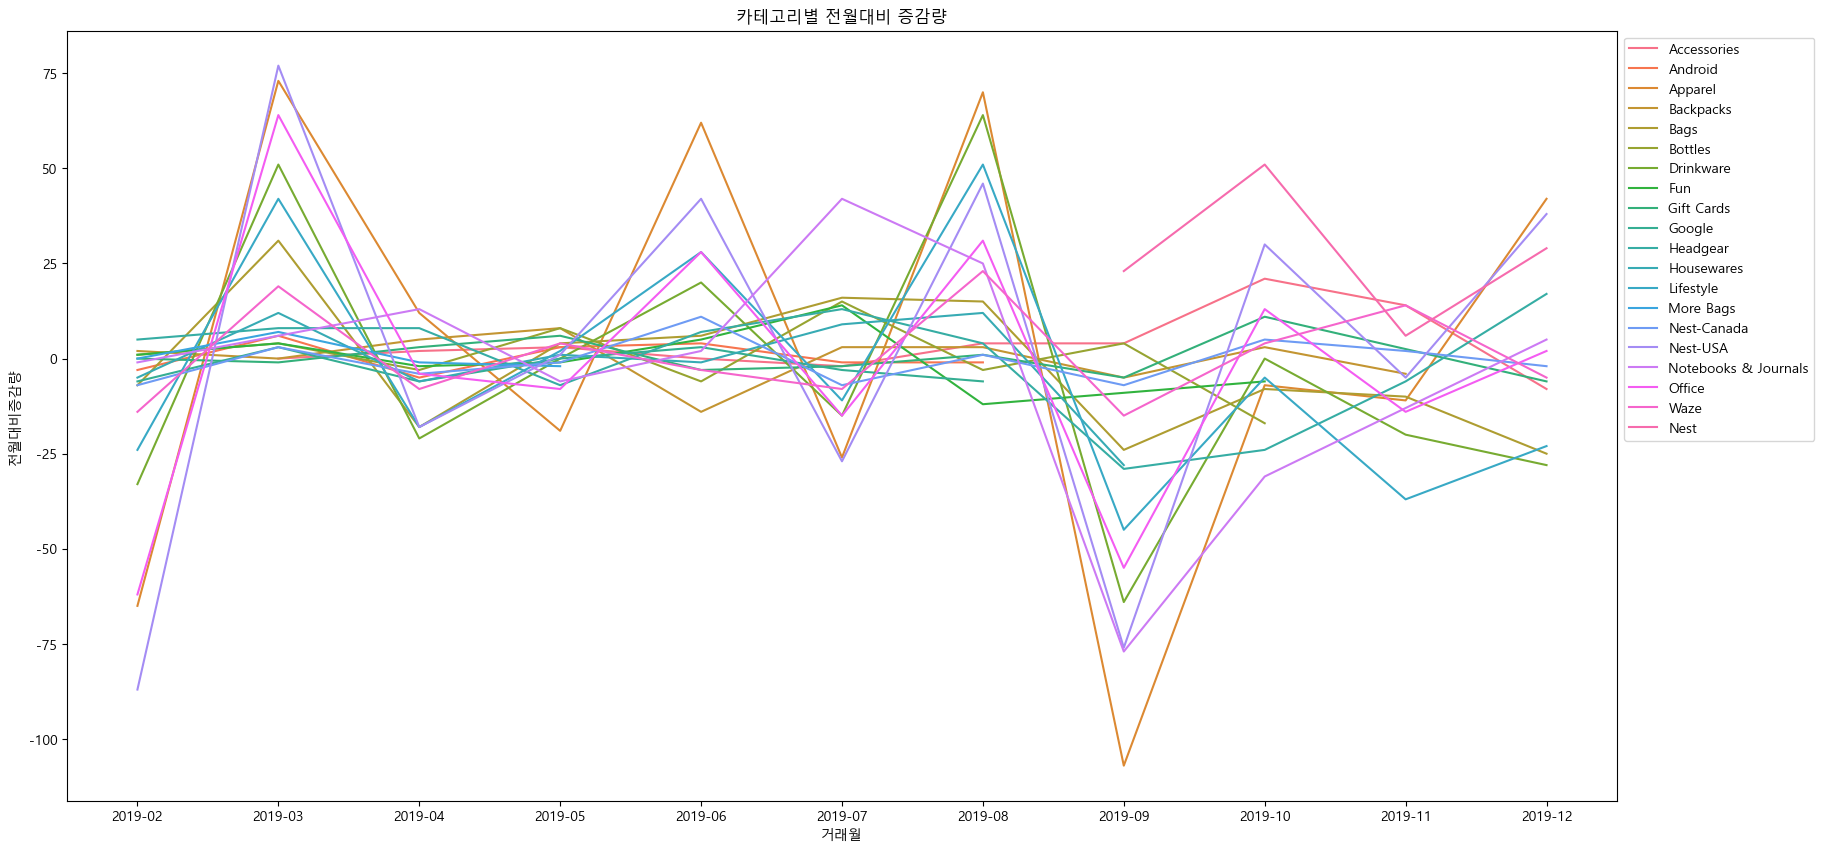

In [16]:
plt.figure(figsize = (20, 10))
sns.lineplot(data = customer_cnt, x = '거래월', y = '전월대비증감량',hue = '제품카테고리')

plt.title('카테고리별 전월대비 증감량')
plt.legend(bbox_to_anchor = (1.0, 1))
plt.show()

### 2. Coupon 데이터 확인

1,4,7,10월은 10%, 
2,5,8,11월은 20%, 
3,6,9,12월은 30%의 할인율을 가진다. 

In [17]:
coupon.groupby('월')['할인율'].mean()

월
2019-01    10.0
2019-02    20.0
2019-03    30.0
2019-04    10.0
2019-05    20.0
2019-06    30.0
2019-07    10.0
2019-08    20.0
2019-09    30.0
2019-10    10.0
2019-11    20.0
2019-12    30.0
Name: 할인율, dtype: float64

각 물품들의 평균 금액은 8월에 제일 낮았다가 이후로 높아지고 있는 추세를 보인다.  
유저 수가 8월에 급증했던 이유는 낮은 금액으로 인한 것으로 보여진다.  
반면, 8월 대비 9월의 경우 물품의 평균 금액이 약 25% 높아져 유저들이 거부반응을 일으켰을 가능성이 있을 것으로 해석된다.  

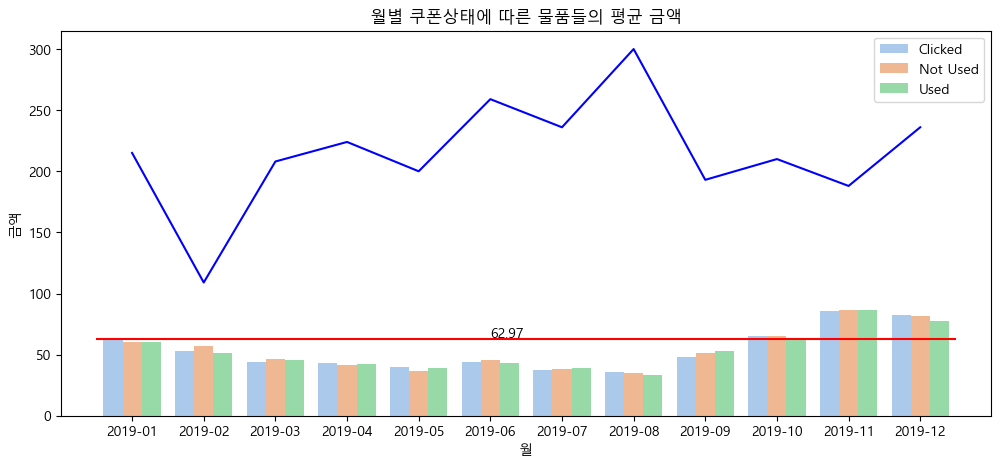

In [18]:
coupon2 = df.assign(Month = pd.to_datetime(sales['거래날짜']).dt.to_period('M')).groupby(['Month', '쿠폰상태'])[['평균금액']].mean().reset_index()

plt.figure(figsize = (12, 5))
sns.barplot(data = coupon2, x = 'Month', y = '평균금액', hue = '쿠폰상태')
plt.hlines(df.거래가.mean(), xmin = -0.5, xmax = 11.5, colors = 'red')
plt.text(s = f'{round(df.거래가.mean(), 2)}',x = 5, y = df.거래가.mean() + 1)


sns.lineplot( x = user_counts_by_month.index.astype(str), y = user_counts_by_month.values, color = 'blue')
plt.xlabel('월')
plt.ylabel('금액')
plt.title('월별 쿠폰상태에 따른 물품들의 평균 금액')
plt.show()

가설 및 주요 결과 정리  
1. Nest를 구매한 유저와 그렇지 않은 유저의 방문 리텐션이 다를 것이다.(가설)  
2. 8월 대비 9월의 경우 물품의 평균 금액이 약25% 높아져 유저들이 거부반응을 일으켜 거래 및 유저 수가 감소했을 수 있다.  
3. Nest 제품군이 대부분의 매출을 차지하고 있으나 office나 의류 등 일상에 사용하는 제품의 판매 수가 더 많다. 
4. 20개의 제품 내 유사한 제품군을 그룹화해본다.  
   크게 Nest제품군, 전자제품군, 패션류 등이 유사하게 묶일 것이다.(가설)

## 5. 가설검증 및 방향성 설정  



### 1. Nest 구매 유저와 비구매 유저간 리텐션이 다를 것이다.

In [19]:
def month_diff(start_date, end_date):
    return (end_date.year - start_date.year) * 12 + end_date.month - start_date.month

df['월'] = pd.to_datetime(df['월'])
df['거래날짜'] = pd.to_datetime(df['거래날짜'])
df['최초거래월'] = df.groupby('고객ID')['월'].transform('min')
df['경과월'] = df.apply(lambda row: month_diff(row['최초거래월'], row['거래날짜']), axis=1)
df.sample(10)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,월,쿠폰코드,할인율,GST,거래가,최초거래월,경과월
46105,USER_0257,Transaction_20996,2019-11-14,Product_0917,Lifestyle,1,2.80,6.00,Not Used,2019-11-01,EXTRA20,20.0,0.18,3.304000,2019-08-01,3
5424,USER_0830,Transaction_2815,2019-02-13,Product_0872,Bags,8,8.79,6.50,Not Used,2019-02-01,AIO20,20.0,0.18,10.372200,2019-02-01,0
36398,USER_0428,Transaction_16174,2019-09-04,Product_0867,Lifestyle,2,2.10,6.00,Clicked,2019-09-01,EXTRA30,30.0,0.18,2.478000,2019-07-01,2
5287,USER_1430,Transaction_2749,2019-02-12,Product_0961,Notebooks & Journals,1,14.99,6.50,Clicked,2019-02-01,NJ20,20.0,0.05,15.739500,2019-02-01,0
23049,USER_0846,Transaction_10809,2019-06-19,Product_0937,Office,2,1.59,12.48,Used,2019-06-01,OFF30,30.0,0.10,2.498571,2019-06-01,0
15565,USER_1433,Transaction_7420,2019-04-28,Product_0914,Office,35,0.79,30.35,Not Used,2019-04-01,OFF10,10.0,0.10,0.869000,2019-02-01,2
44478,USER_1056,Transaction_20103,2019-11-01,Product_0618,Apparel,1,4.00,6.00,Clicked,2019-11-01,SALE20,20.0,0.18,4.720000,2019-11-01,0
18491,USER_1192,Transaction_8750,2019-05-17,Product_0229,Apparel,1,10.63,6.00,Clicked,2019-05-01,SALE20,20.0,0.18,12.543400,2019-05-01,0
9626,USER_1185,Transaction_4829,2019-03-17,Product_0891,Drinkware,4,19.99,6.50,Used,2019-03-01,EXTRA30,30.0,0.18,33.697429,2019-03-01,0
16740,USER_0119,Transaction_7989,2019-05-05,Product_0006,Apparel,1,15.99,6.00,Clicked,2019-05-01,SALE20,20.0,0.18,18.868200,2019-05-01,0


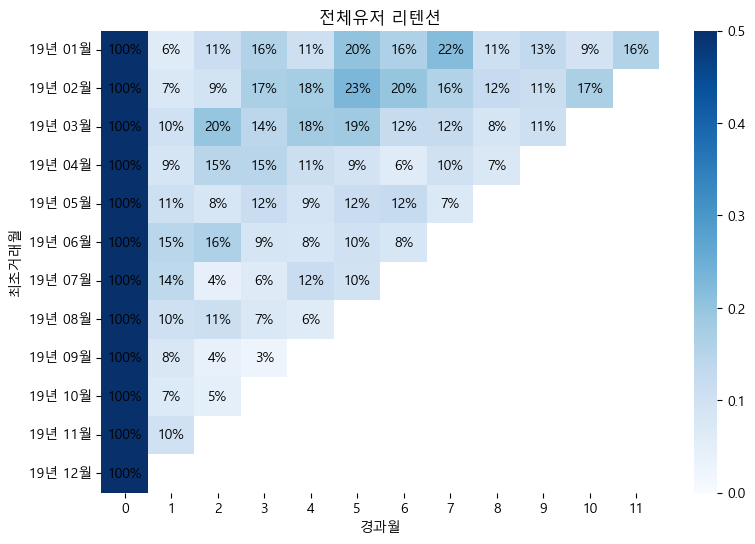

In [20]:
def cohort_chart(df, title = '코호트'):
    cohort_data = df.groupby(['최초거래월', '경과월'])['고객ID'].nunique().reset_index()
    cohort_counts = cohort_data.pivot(index = '최초거래월', columns = '경과월', values = '고객ID')

    cohort_size = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_size, axis = 0)

    plt.figure(figsize = (9, 6))
    plt.title(title)
    ax = sns.heatmap(data = retention, annot = False, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'Blues')

    for i in range(retention.shape[0]):
            for j in range(retention.shape[1]):
                if retention.iloc[i, j] != retention.iloc[i, j]:
                    continue
                ax.text(j+0.5, i+0.5, f'{retention.iloc[i, j]*100:.0f}%', ha='center', va='center', fontsize=10)
        
        # ax.set_yticklabels([f'{int(label.get_text())}월' for label in ax.get_yticklabels()], rotation=0)
    ax.set_yticklabels([f'19년 {label.get_text().split("-")[1]}월' for label in ax.get_yticklabels()], rotation=0)
    plt.show()
    
    return

cohort_chart(df, '전체유저 리텐션')

In [21]:
nest = ['Nest', 'Nest-USA', 'Nest-Canada']


targetidx = df[df.제품카테고리.isin(nest)].index

target_user = df[df.index.isin(targetidx)]
nontarget_user = df[~df.index.isin(targetidx)]

Nest구매 유저와 비구매 유저 리텐션을 확인했을 때 각 코호트별 리텐션 추세는 큰 차이가 없는 것으로 확인했다.  
단, 연초의 Nest구매 유저의 경우 연말에, 비구매 유저의 경우 연초에 리텐션이 상대적으로 높음을 볼 수 있다.  
이는 Nest 제품의 구매주기가 길어 연초에 구매 후 연말에 한번 더 구매하려는 경향이 있기 때문으로 보여진다.  
  
정리하면, Nest가 매출이 높기는 하나 해당 이커머스 사이트에서 Nest만 구매하는 경우는 잘 없다. 그 이유는 제품 구매주기가 길기 때문이며 그 외의 상황에는 Nest 외에 다른 제품들을 구매하기 위해 방문한다고 볼 수 있다.

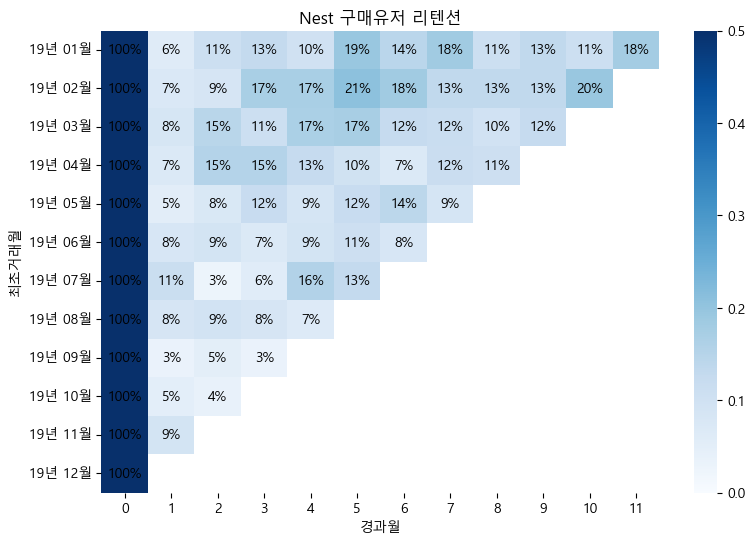

In [22]:
cohort_chart(target_user, title = 'Nest 구매유저 리텐션')

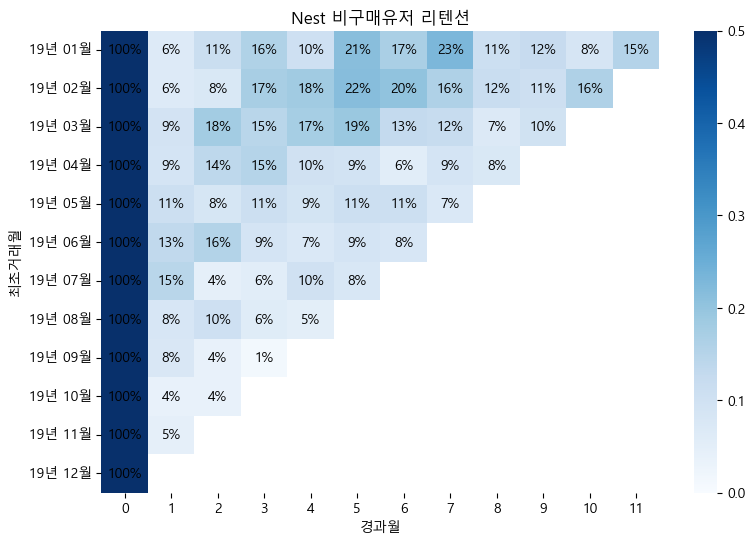

In [23]:
cohort_chart(nontarget_user, title = 'Nest 비구매유저 리텐션')

### 2. 전자제품, 패션, Nest 등 특정 제품군끼리 유사하게 묶일 것이다.

계층적 군집화를 통해 category를 그룹화한다.  
제품의 구매유저수, 거래가, 구매주기, 구매수량을 통해 유사제품군을 그룹화 시도한다.  
계층군집을 시도하는 이유는 category는 20개로 군집화 할 데이터의 개수가 매우 적기 때문에 계층군집이 적절할 것이라 생각했기 때문이다.  

구매주기(거래주기) 정의  
각 제품을 구매한 고객이 여러번 방문했을 경우 그 거래날짜간 차이의 중앙값으로 결정한다.

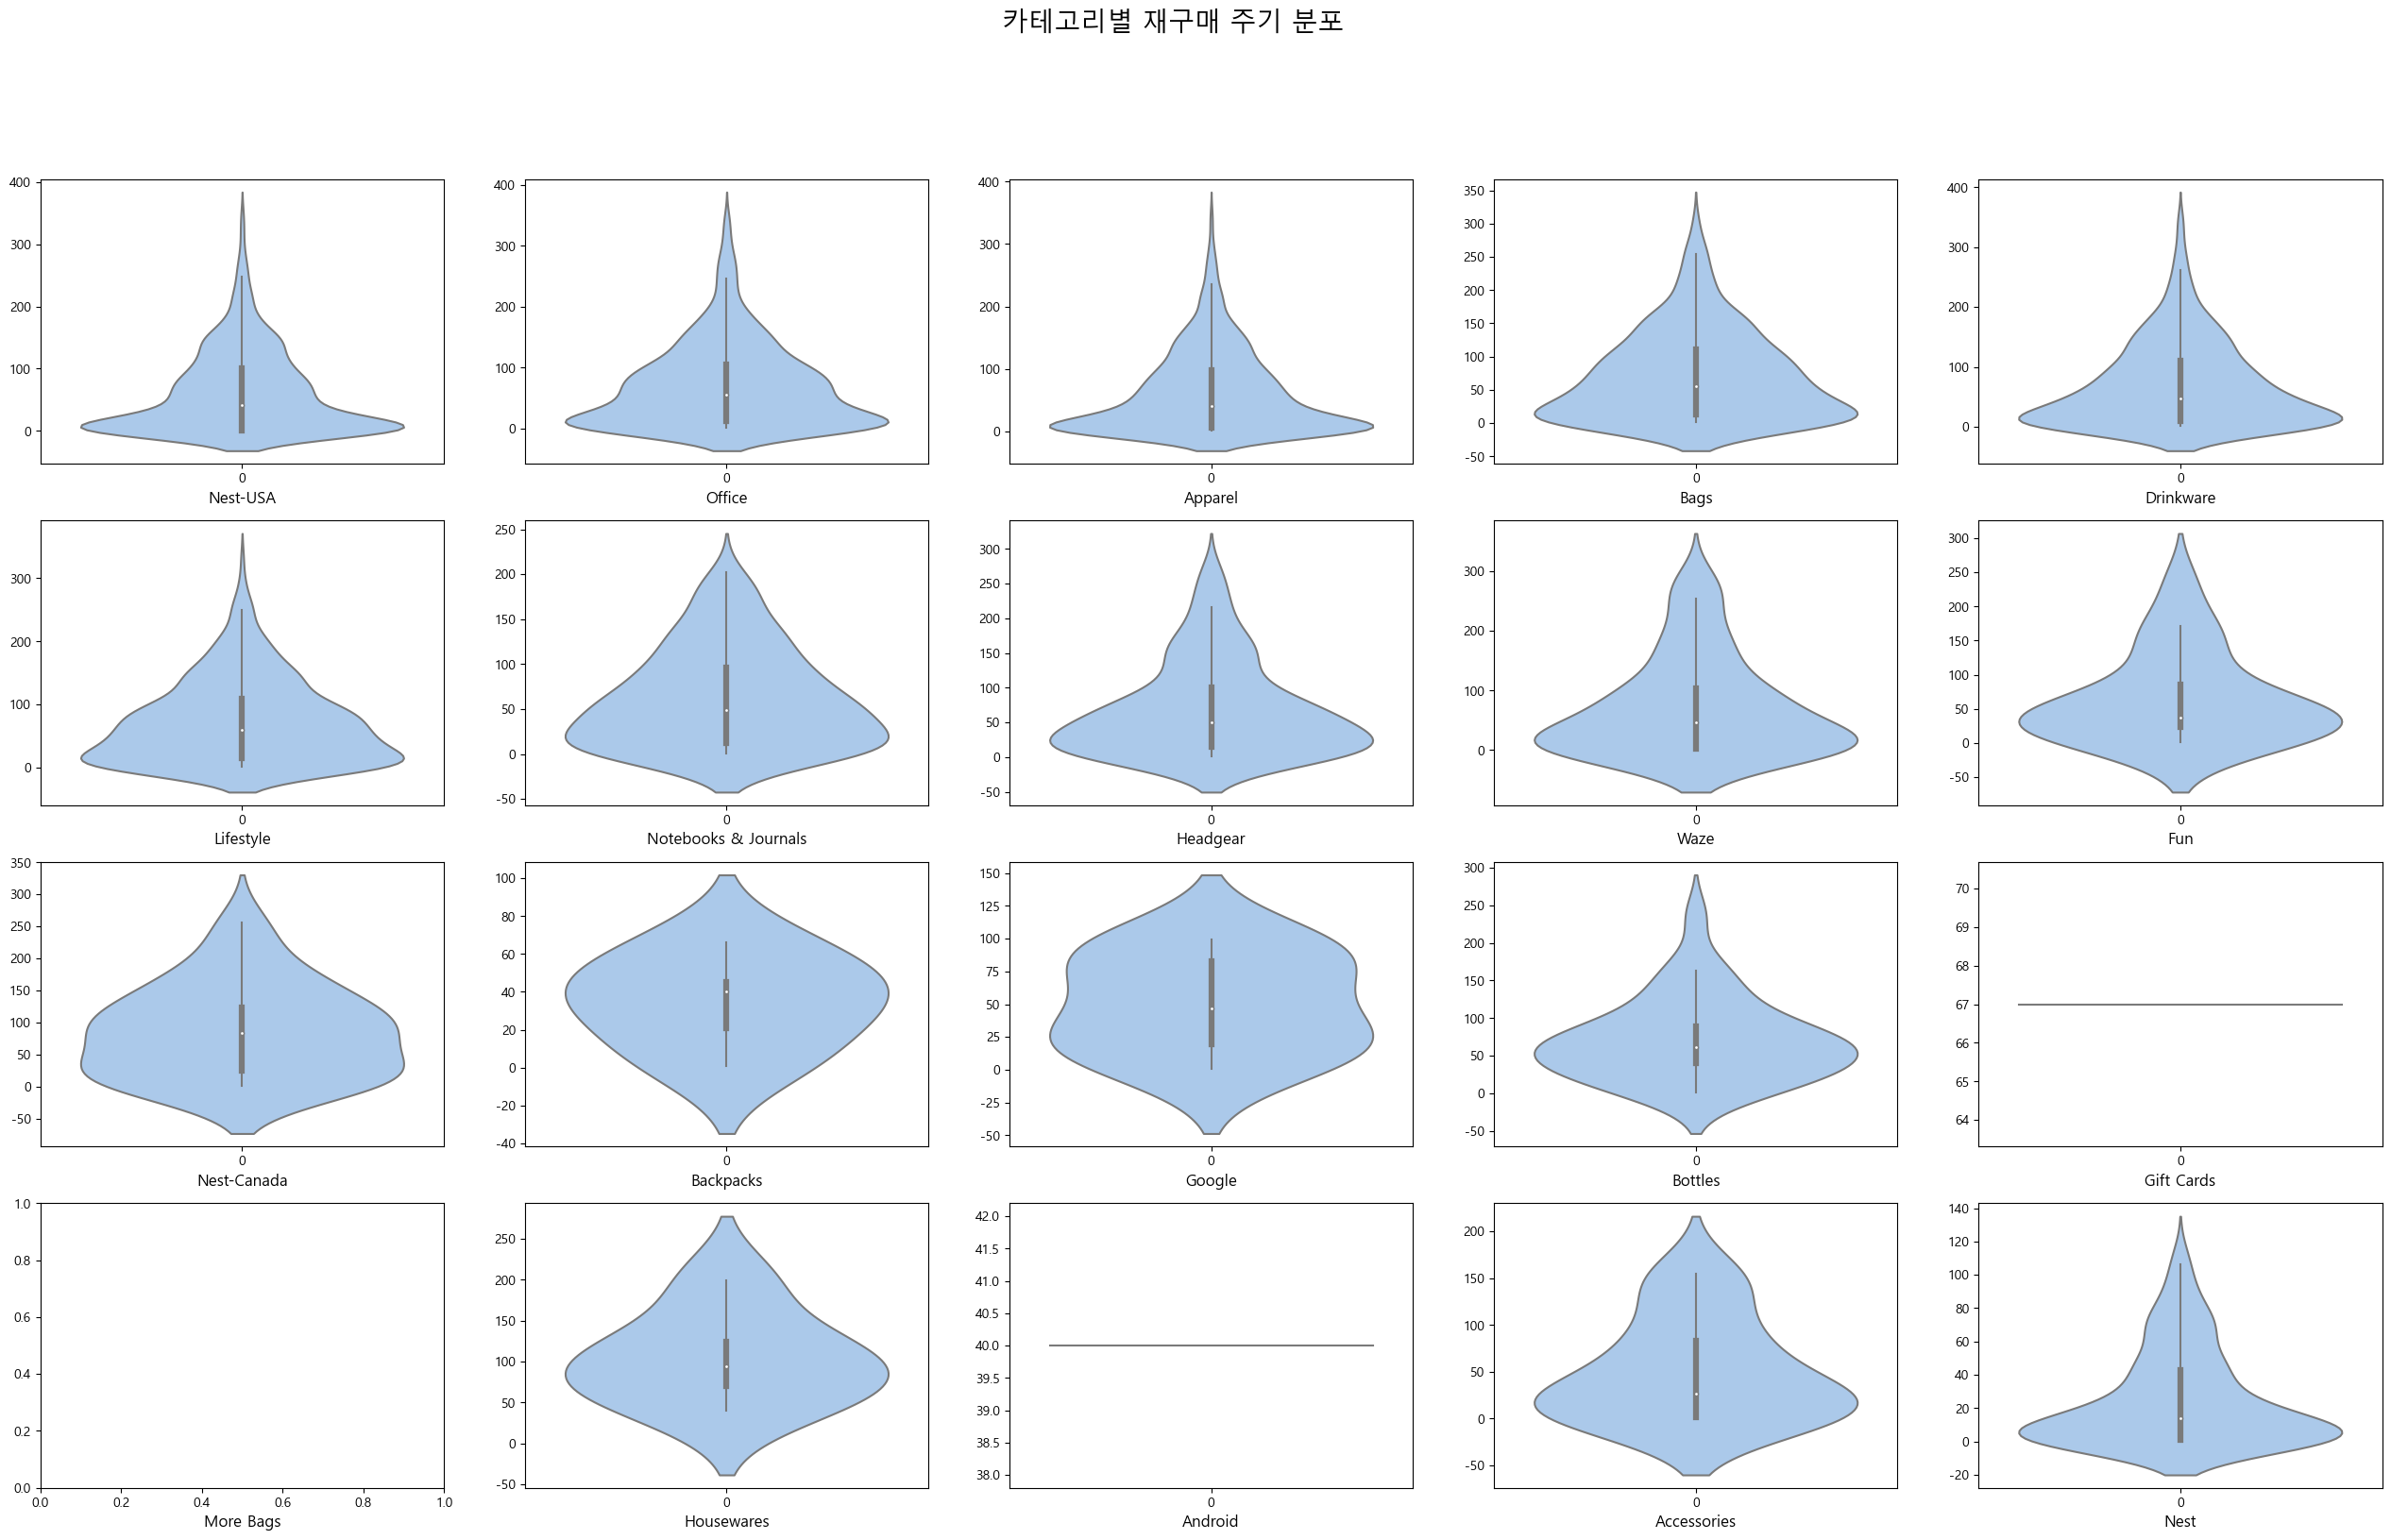

In [24]:
categories = df.제품카테고리.unique()
fig, ax = plt.subplots( nrows = 4, ncols = 5, figsize = (32, 18))
for idx, cat in enumerate(categories):
    r, c = idx//5, idx%5
    
    periods = []

    for x in df.query(f'`제품카테고리` == "{cat}"').groupby('고객ID')['거래날짜'].unique():
        if len(x) > 1:
            for i in range(len(x)-1):
                periods.append((x[i+1] - x[i]).days)
                
    if cat == 'More Bags':
        ax[r][c].set_xlabel(cat, fontsize = 12)
        continue
    
    sns.violinplot(periods, ax = ax[r][c])
    ax[r][c].set_xlabel(cat, fontsize = 12)

plt.suptitle('카테고리별 재구매 주기 분포', fontsize = 20)
plt.show()

카테고리별 구매주기의 분포를 확인했을 때, 많은 유저들이 maximum값보다는 0에 더 가깝게 구매주기를 가짐을 확인할 수 있다. 이에 따라 median 값을 선택하여 구매주기를 선택한다.

In [25]:
from collections import Counter

median_period = {}
most_common = {}
for cat in categories:
    periods = []

    for x in df.query(f'`제품카테고리` == "{cat}"').groupby('고객ID')['거래날짜'].unique():
        if len(x) > 1:
            tmp = []
            for i in range(len(x)-1):
                tmp.append((x[i+1] - x[i]).days)

            periods.append(np.median(tmp))
    if cat == 'Bags':
        t = np.median(periods)           
    if cat == 'More Bags':
        median_period[cat] = t
        continue
    
    median_period[cat] = np.median(periods)
    most_common[cat] = Counter(periods).most_common()[0][0]
median_period

{'Nest-USA': 58.5,
 'Office': 75.5,
 'Apparel': 59.75,
 'Bags': 83.0,
 'Drinkware': 74.0,
 'Lifestyle': 75.75,
 'Notebooks & Journals': 61.0,
 'Headgear': 61.5,
 'Waze': 52.5,
 'Fun': 46.0,
 'Nest-Canada': 83.0,
 'Backpacks': 41.75,
 'Google': 60.0,
 'Bottles': 71.0,
 'Gift Cards': 67.0,
 'More Bags': 83.0,
 'Housewares': 82.0,
 'Android': 40.0,
 'Accessories': 41.0,
 'Nest': 14.0}

거래주기를 기준으로 평균적인 재구매 주기는 2달정도 임을 알 수 있다.

In [26]:
np.mean(list(median_period.values()))

61.5125

구매유저수, 거래가, 구매주기, 수량과 같은 feature를 통해 군집화한 결과,  
fashion, office, nest 등과 같이 제품군으로 정성적으로 묶일 것이라 예상했던 것과 달랐다.  
Apparel, Nest-USA, Nest 등 매출 및 인기도가 높은 제품끼리 묶이는 것은 이해가 되나 GiftCard와 같이 매출 및 기여도 부분이 좋지 않은 제품이 같은 그룹에 묶였다는 점에서 군집화를 신뢰하기 어렵다고 판단하였다.  

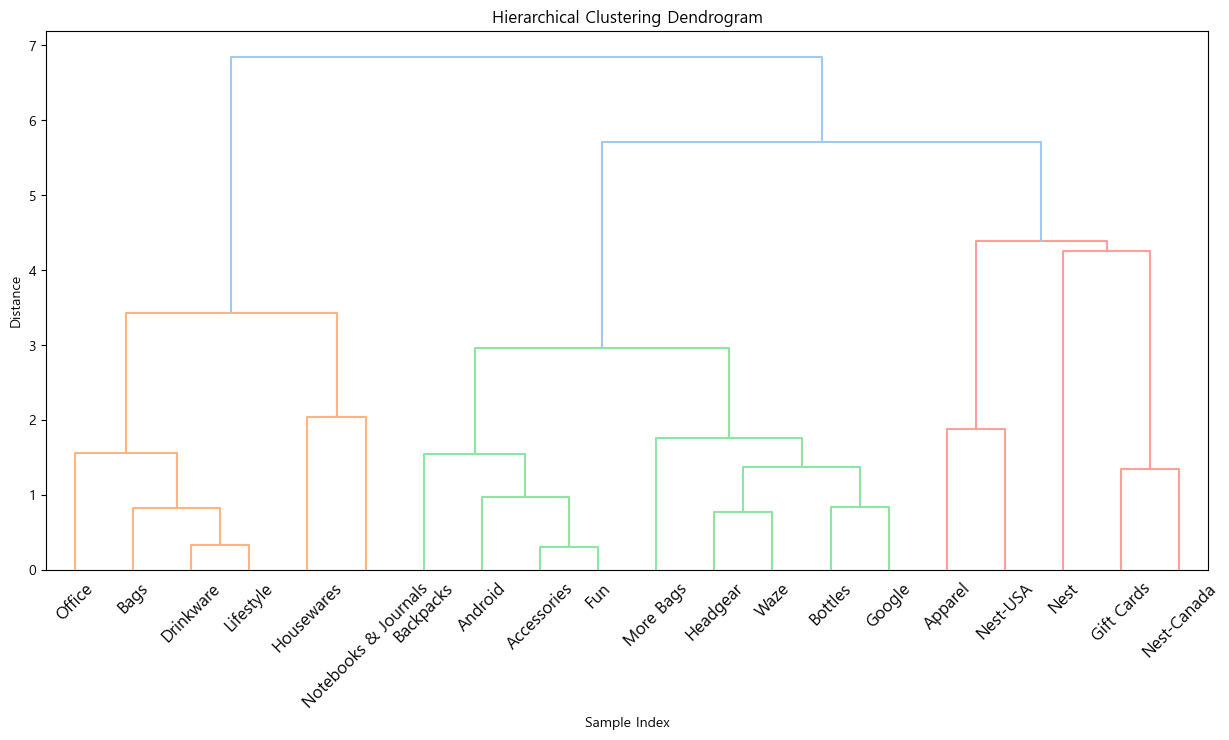

In [27]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

def clustering(df):
    df['구매주기'] = df['제품카테고리'].map(median_period)
    cat_data = df.groupby('제품카테고리')[['고객ID']].nunique().reset_index()
    cat_data = cat_data.rename(columns = {'고객ID' : '구매유저수'})
    cat_data = cat_data.merge(df.groupby('제품카테고리')[['거래가', '구매주기', '수량']].mean().reset_index(), on ='제품카테고리', how = 'left')
    cat_data = cat_data.set_index('제품카테고리')
    
    ss = StandardScaler()
    scaled_data = pd.DataFrame(ss.fit_transform(cat_data), columns = cat_data.columns)
    scaled_data.index = cat_data.index
    
    linked = linkage(scaled_data, method='ward')
    plt.figure(figsize=(15, 7))
    dendrogram(linked, labels = scaled_data.index)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xticks(rotation = 45)
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.show()
    
clustering(df)
    

제품 카테고리 그룹화 방향성  
  
제품의 특성을 대변할 수 있는 변수를 생성한다.  
이에 따라, 인기도와 매출기여도를 정의하고 이를 기준으로 나눠보고자 했다.  

제품 인기도  
  
제품의 인기도에 기여할 수 있는 여러 변수는 다음과 같이 생각했다.    
구매유저비율 : 얼마나 많은 유저가 구매했는가?
유저당평균구매횟수 : 한 유저당 평균적으로 얼마나 구매하는가?  
구매당수량 : 한번의 거래에 얼마나 많이 거래하는가?  
판매수량 : 얼마나 많이 판매 되었는가? 
판매수량비율 : 판매된 제품중 어느정도 비중을 차지하는가?
  
이중, 유저에게 얼마나 사랑받는 제품인가?의 관점에 영향을 미치는 요인은  
  
구매유저비율, 유저당평균구매횟수로 정의하였다.  
전체 유저에게 얼마나 인기가 있는지, 각 유저가 얼마나 많이 구매하는지를 기준으로 인기도를 산출했다.  
나머지 변수는 제품 자체가 얼마나 팔리고 구매하는지, 즉, 제품 자체의 특성에 대한 변수로 보았기 때문에 계산에서 제외했다.  

인기도는  
  
0.5 이상이면 상  
0.2 이하이면 하  
그 외 중으로 등급을 부여하였다. 

In [28]:
def hot_score(df):
    hot_item = df.groupby(['제품카테고리'])[['고객ID']].nunique()/ df.고객ID.nunique()
    hot_item.columns = ['구매유저비율']
    hot_item['구매유저비율'] = hot_item['구매유저비율'].round(2)
    
    user_purchase_count = df.groupby(['고객ID', '제품카테고리']).size().reset_index(name = '구매횟수')
    category_purchase_count = df.groupby('제품카테고리').size().reset_index(name = '총구매횟수')
    category_user_avg_purchase = user_purchase_count.groupby('제품카테고리')['구매횟수'].mean().reset_index(name = '유저당평균구매횟수')
    result = pd.merge(category_purchase_count, category_user_avg_purchase, on='제품카테고리')
    
    cat_sales_num = df.groupby('제품카테고리')['수량'].sum().reset_index(name = '판매수량')

    hot_item = hot_item.reset_index().merge(result, how = 'left', on ='제품카테고리').merge(cat_sales_num, how = 'left', on = '제품카테고리').sort_values(by = ['유저당평균구매횟수', '구매유저비율'], ascending = False).set_index('제품카테고리')
    hot_item['구매당수량'] = round(hot_item['판매수량']/hot_item['총구매횟수'], 2)
    hot_item['판매수량비율'] = round(hot_item['판매수량']/ hot_item['판매수량'].sum(),5)
    hot_item['유저당평균구매횟수비'] = round(hot_item['유저당평균구매횟수']/ hot_item['유저당평균구매횟수'].max(),2)
    
    hot_item['score'] = (hot_item['구매유저비율'] + hot_item['유저당평균구매횟수비'])/2
    hot_item = hot_item.sort_values('score', ascending = False)
    hot_item['인기도'] = np.where(hot_item['score'] >= 0.5, '상', np.where(hot_item['score'] >= 0.2, '중', '하'))

    return hot_item

hot_item = hot_score(df)
hot_item

,구매유저비율,총구매횟수,유저당평균구매횟수,판매수량,구매당수량,판매수량비율,유저당평균구매횟수비,score,인기도
제품카테고리,,,,,,,,,
Apparel,0.90,18126,13.700680,32438,1.79,0.13628,1.00,0.950,상
Nest-USA,0.86,14013,11.121429,21430,1.53,0.09003,0.81,0.835,상
Office,0.75,6513,5.904805,88383,13.57,0.37131,0.43,0.590,상
Drinkware,0.63,3483,3.789989,30501,8.76,0.12814,0.28,0.455,중
Lifestyle,0.56,3092,3.784578,24881,8.05,0.10453,0.28,0.420,중
Bags,0.50,1882,2.585165,15273,8.12,0.06416,0.19,0.345,중
Nest,0.35,2198,4.259690,2837,1.29,0.01192,0.31,0.330,중
Headgear,0.29,771,1.814118,3533,4.58,0.01484,0.13,0.210,중
Notebooks & Journals,0.26,749,1.955614,9556,12.76,0.04015,0.14,0.200,중


제품 매출 기여도  
EDA를 통해 매출의 대부분을 차지하는 제품군이 있음을 파악했다.  
따라서 파레토 차트를 통해 고매출 / 저매출 상품군을 나눈다.    
이때 배송료는 유저의 거래단위 별 한번씩 발생하며 제품 자체로 인한 순 거래액이 필요하므로 계산에서 제외했다.

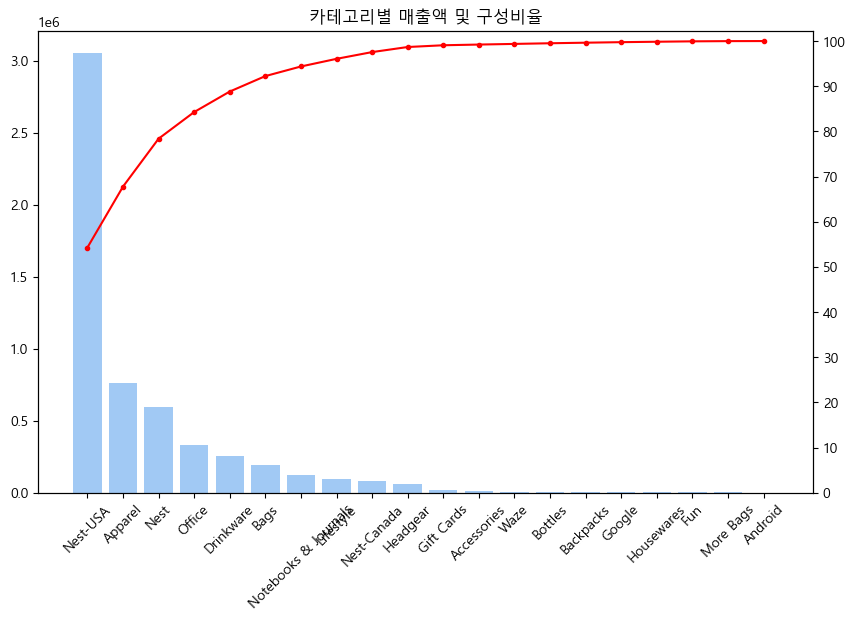

In [29]:
def pareto_chart(df):
    df['매출액'] = df['거래가']*df['수량']
    revenue = df.groupby('제품카테고리')[['매출액']].sum().sort_values('매출액', ascending = False)
    revenue['누적pct'] = revenue.매출액.cumsum()/ revenue.매출액.sum() * 100

    fig, ax = plt.subplots(figsize = (10, 6))

    g1 = ax.bar(revenue.index, revenue.매출액)

    ax.set_xticklabels(revenue.index, rotation = 45)

    ax2 = ax.twinx()

    g2 = ax2.plot(revenue.index, revenue.누적pct, color = 'red', marker = '.')
    ax2.set_yticks(range(0, 101, 10))

    # g = g1 + g2
    # # labels = [x.get_label() for x in g]
    # ax.legend([g2.get_label()])
    plt.title('카테고리별 매출액 및 구성비율')
    plt.show()
    return revenue

revenue = pareto_chart(df)

20개중 5개(25%)의 제품에 의해 약 88%의 매출이 발생하고 있다.  
Nest-usa, apparel, nest, office, drinkware가 그 5개이다.  
nest usa의 매출비율이 압도적이기 때문에 이것 하나만 떼어서 높음으로 친다.  
Apparel, Nest는 10%매출로 높은편은 아니지만 순위상 중간으로 부여하고  
그 외 제품들은 낮은 제품군으로 분류한다. 

In [30]:
revenue['pct'] = round(revenue['매출액']/revenue['매출액'].sum(), 3)
revenue['매출기여도'] = np.where(revenue['pct'] >= 0.5, '높음', (np.where(revenue['pct'] > 0.1, '중간', '낮음')))
revenue

,매출액,누적pct,pct,매출기여도
제품카테고리,,,,
Nest-USA,3.056530e+06,54.293210,0.543,높음
Apparel,7.592976e+05,67.780631,0.135,중간
Nest,5.970524e+05,78.386086,0.106,중간
Office,3.320212e+05,84.283785,0.059,낮음
Drinkware,2.556148e+05,88.824277,0.045,낮음
Bags,1.924553e+05,92.242865,0.034,낮음
Notebooks & Journals,1.198576e+05,94.371899,0.021,낮음
Lifestyle,9.518279e+04,96.062633,0.017,낮음
Nest-Canada,8.418402e+04,97.557996,0.015,낮음


In [31]:
cat_grouping = hot_item.reset_index().merge(revenue.reset_index(), on = '제품카테고리')[['제품카테고리', 'score', 'pct','인기도', '매출기여도']]
def grid(cat_grouping):
    if cat_grouping['인기도'] == '상' and cat_grouping['매출기여도'] == '높음':
        return 1
    elif cat_grouping['인기도']  == '상' and cat_grouping['매출기여도'] == '중간':
        return 2
    elif cat_grouping['인기도']  == '상' and cat_grouping['매출기여도'] == '낮음':
        return 3
    elif cat_grouping['인기도']  == '중' and cat_grouping['매출기여도'] == '높음':
        return 4
    elif cat_grouping['인기도']  == '중' and cat_grouping['매출기여도'] == '중간':
        return 5
    elif cat_grouping['인기도']  == '중' and cat_grouping['매출기여도'] == '낮음':
        return 6
    elif cat_grouping['인기도']  == '하' and cat_grouping['매출기여도'] == '높음':
        return 7
    elif cat_grouping['인기도']  == '하' and cat_grouping['매출기여도'] == '중간':
        return 8
    else:
        return 9
        
        
cat_grouping['group'] = cat_grouping.apply(grid, axis = 1)
cat_grouping

,제품카테고리,score,pct,인기도,매출기여도,group
0,Apparel,0.950,0.135,상,중간,2
1,Nest-USA,0.835,0.543,상,높음,1
2,Office,0.590,0.059,상,낮음,3
3,Drinkware,0.455,0.045,중,낮음,6
4,Lifestyle,0.420,0.017,중,낮음,6
5,Bags,0.345,0.034,중,낮음,6
6,Nest,0.330,0.106,중,중간,5
7,Headgear,0.210,0.011,중,낮음,6
8,Notebooks & Journals,0.200,0.021,중,낮음,6
9,Waze,0.170,0.001,하,낮음,9


인기도와 매출기여도 점수에 따른 카테고리를 확인해보면  
크게 6개의 그룹으로 나뉠 수 있음을 볼 수 있다.  
1. Nest-USA : 인기도와 매출기여도가 높은 제품  
2. Apparel : 인기도는 높지만 매출 기여는 중간인 제품  
3. Nest :  인기도와 매출기여 둘 다 중간인 제품  
4. Office : 인기도는 높지만 매출기여가 낮은 제품  
5. Headgear ~ Drinkware : 인기도는 중간이나 매출기여가 낮은 제품  
6. 기타 : 인기도 및 매출기여가 낮은 제품

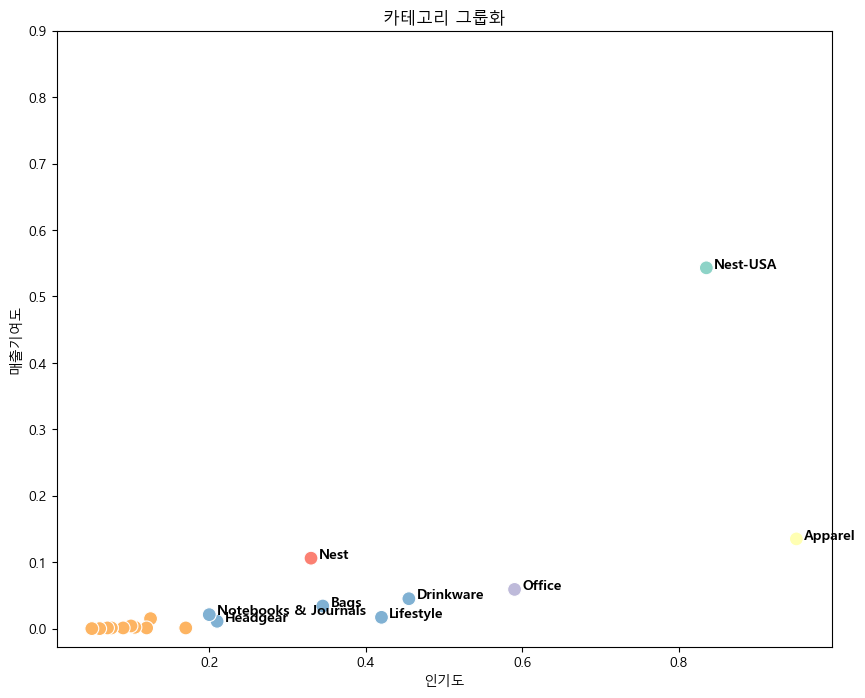

In [32]:
# 그래프 그리기
plt.figure(figsize = (10, 8))
sns.scatterplot(data=cat_grouping, x='score', y='pct', hue = 'group', palette = 'Set3', s = 100, legend = False)

for i in range(cat_grouping.shape[0]):
    if cat_grouping['score'][i] < 0.2 and cat_grouping['pct'][i] < 0.2:
        continue
    
    plt.text(cat_grouping['score'][i]+0.01, cat_grouping['pct'][i], cat_grouping['제품카테고리'][i], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.yticks(np.arange(0, 1, 0.1))
plt.title('카테고리 그룹화')
plt.xlabel('인기도')
plt.ylabel('매출기여도')

plt.show()

유저별로 6개의 그룹중 어떤 그룹의 제품을 주로 구매하는지 파악한다.  
각 유저별로 각 그룹에 해당하는 제품을 몇번씩 거래했는지 빈도를 파악한 후 최빈값을 주 구매 제품군으로 정의한다.  

In [53]:
nest_usa = cat_grouping.query('`group` == 1').제품카테고리.to_list()
apparel = cat_grouping.query('`group` == 2').제품카테고리.to_list()
nest = cat_grouping.query('`group` == 5').제품카테고리.to_list()
office = cat_grouping.query('`group` == 3').제품카테고리.to_list()
life = cat_grouping.query('`group` == 6').제품카테고리.to_list()
gift = cat_grouping.query('`group` == 9').제품카테고리.to_list()

In [45]:
user_mode = df.groupby(['고객ID', '제품카테고리'])['거래ID'].count().reset_index(name = '구매횟수').pivot(index='고객ID', columns='제품카테고리', values='구매횟수').fillna(0)

In [62]:
user_mode['nest_usa'] = user_mode[nest_usa].values.flatten()
user_mode['apparel'] = user_mode[apparel].values.flatten()
user_mode['nest'] = user_mode[nest].values.flatten()
user_mode['office'] = user_mode[office].values.flatten()
user_mode['life'] = user_mode[life].sum(axis = 1).values
user_mode['gift'] = user_mode[gift].sum(axis = 1).values
    
user_mode['group'] = user_mode[['nest_usa', 'apparel', 'nest', 'office', 'life', 'gift']].T.idxmax()
user_mode

제품카테고리,Accessories,Android,Apparel,Backpacks,Bags,Bottles,Drinkware,Fun,Gift Cards,Google,...,Notebooks & Journals,Office,Waze,nest_usa,apparel,nest,office,life,gift,group
고객ID,,,,,,,,,,,,,,,,,,,,,
USER_0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,apparel
USER_0001,1.0,0.0,19.0,0.0,2.0,0.0,2.0,0.0,0.0,1.0,...,0.0,11.0,0.0,20.0,19.0,2.0,11.0,6.0,2.0,nest_usa
USER_0002,0.0,0.0,4.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,...,0.0,7.0,0.0,2.0,4.0,0.0,7.0,10.0,0.0,life
USER_0003,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,7.0,0.0,0.0,2.0,2.0,apparel
USER_0004,0.0,0.0,15.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,7.0,0.0,4.0,15.0,2.0,7.0,8.0,0.0,apparel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
USER_1463,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,4.0,0.0,0.0,2.0,1.0,apparel
USER_1464,1.0,0.0,17.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,...,4.0,4.0,1.0,6.0,17.0,0.0,4.0,9.0,4.0,apparel
USER_1465,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,apparel


In [63]:
df = df.merge(user_mode.reset_index()[['고객ID','group']], on = '고객ID')
df.sample(3)

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,월,쿠폰코드,할인율,GST,거래가,최초거래월,경과월,구매주기,매출액,group
18964,USER_0734,Transaction_4252,2019-03-07,Product_0915,Lifestyle,4,2.80,62.74,Clicked,2019-03-01,EXTRA30,30.0,0.18,3.30400,2019-03-01,0,75.75,13.2160,apparel
28940,USER_1342,Transaction_7156,2019-04-24,Product_0891,Drinkware,1,19.99,12.48,Not Used,2019-04-01,EXTRA10,10.0,0.18,23.58820,2019-04-01,0,74.00,23.5882,nest_usa
29772,USER_0784,Transaction_7593,2019-05-01,Product_0870,Lifestyle,40,1.99,6.00,Used,2019-05-01,EXTRA20,20.0,0.18,2.93525,2019-04-01,1,75.75,117.4100,apparel


apparel을 주로 구매하는 유저의 수가 약 50%이며  
nest_usa는 약 35%임을 볼 수 있다.  
그 뒤로 life, office등이 뒤따라옴을 알 수 있다.  
이를 통해 해당 커머스 사이트의 주력제품은 apparel, nest_usa라고 할 수 있다.  
  
nest 제품의 경우 구매 유저수가 없는데, 이는 nest가 8월부터 판매되기 시작한 제품이기 때문이라 볼 수 있다.  
매출기여도는 약 10%로 높게 차지하고 있는 것을 보았을 때 이후 유저들이 더 많이 구매할 제품이라고 볼 수 있을 것이다.  

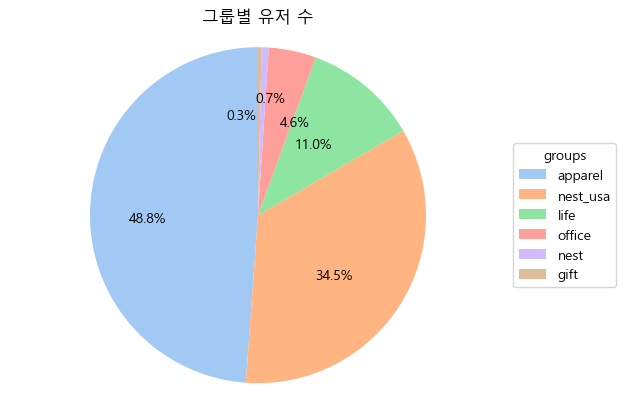

In [64]:
from adjustText import adjust_text

arr = df.groupby('group')['고객ID'].nunique().reset_index(name = '유저수').sort_values('유저수', ascending = False)['유저수'].to_list()
labels = df.groupby('group')['고객ID'].nunique().reset_index(name = '유저수').sort_values('유저수', ascending = False)['group'].to_list()

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(arr, autopct='%1.1f%%', startangle=90)

# 원형의 비율을 맞추기 위해서 aspect 비율을 equal로 설정
ax.axis('equal') 

texts = [*texts, *autotexts]
adjust_text(texts)

# 범례 추가
ax.legend(wedges, labels, title="groups", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title("그룹별 유저 수")
plt.show()

## 6. Modeling(RFM)  
category grouping과 RFM을 결합하여, 고객층 별로 어떤 제품을 주로 구매하는지 파악한다.  

In [68]:
if df.groupby('거래ID')['배송료'].nunique().value_counts().values[0] == df.거래ID.nunique():
    print('각 거래마다 배송료는 한번씩 청구됨')

각 거래마다 배송료는 한번씩 청구됨


배송료를 포함한 Monetary를 산출한다.

In [72]:
def make_rfm(df):
    # df의 매출액 column은 '지불액'과 동일하다.
    user_delivery_fee = df.groupby(['고객ID', '거래ID']).first()[['배송료']].groupby('고객ID').sum().reset_index()
    last_date = df['거래날짜'].max() + pd.DateOffset(days = 1)
    
    rfm = df.groupby(['고객ID']).agg({'거래날짜' : lambda x : (last_date - x.max()).days,
                                          '거래ID' : 'nunique',
                                          '매출액' : 'sum'}).reset_index().copy()
    
    rfm.rename(columns = {'거래날짜' : 'Recency', 
                          '거래ID' : 'Frequency',
                          '매출액' : 'Monetary'}, inplace = True)
    
    rfm['Monetary'] = rfm['Monetary'] + user_delivery_fee['배송료']
    return rfm

rfm = make_rfm(df)

# 유저별 최빈 구매 카테고리를 설정한다.
rfm = rfm.merge(user_mode.reset_index()[['고객ID', 'group']], on = '고객ID')
rfm

,고객ID,Recency,Frequency,Monetary,group
0,USER_0000,108,1,125.983143,apparel
1,USER_0001,60,31,17393.670771,nest_usa
2,USER_0002,74,8,1930.678854,life
3,USER_0003,18,11,1831.836943,apparel
4,USER_0004,108,13,2069.135229,apparel
...,...,...,...,...,...
1463,USER_1463,271,3,704.581533,apparel
1464,USER_1464,88,19,3209.828533,apparel
1465,USER_1465,195,2,136.729622,apparel
1466,USER_1466,70,1,333.800000,nest_usa


각 그룹별 매출을 확인한 결과 Nest-USA 및 Nest가 전체적으로 높은 매출을 보이고 있다.  
각 그룹별 RFM을 수행하게 되면, Nest를 구매한 유저에게 더 높은 등급을 부여할 수 밖에 없게 될 것이다.  
  
따라서, RFM을 통해 전체적인 유저의 등급을 분류하고 그 안에서 어떤 그룹의 제품을 선호하는 유저가 모여있는지를 파악한다. 

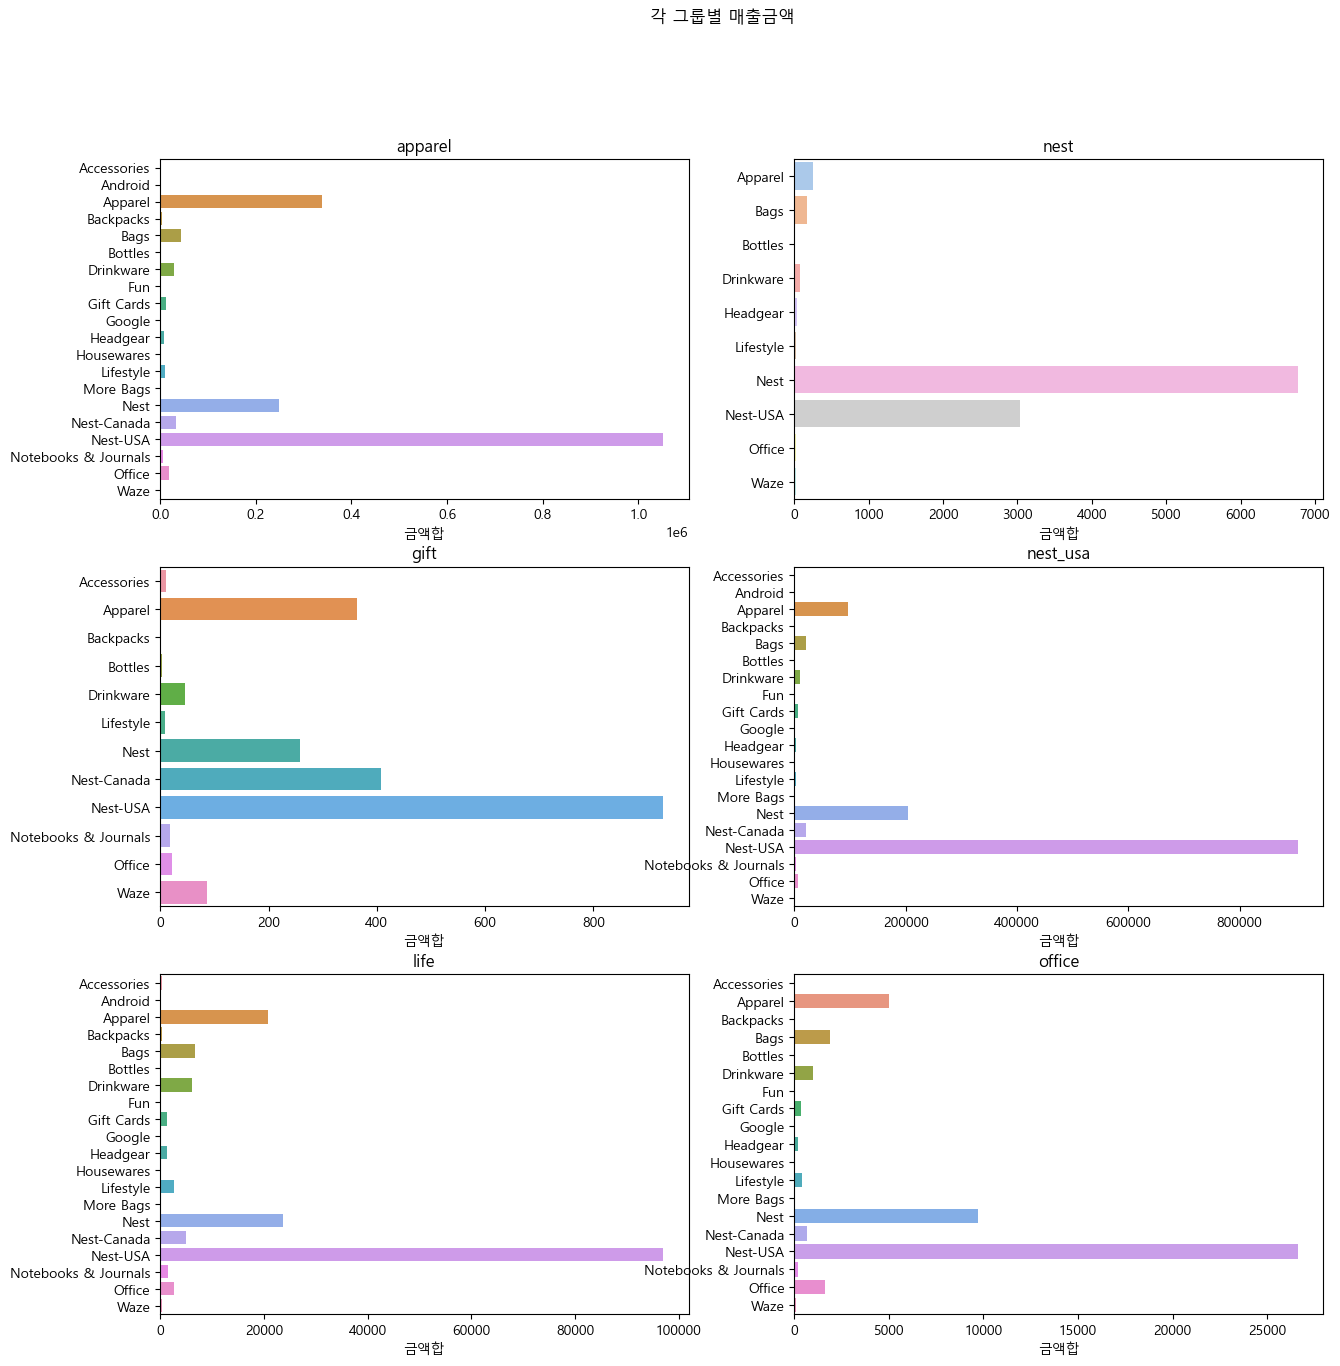

In [75]:
t = df.groupby(['group', '제품카테고리'])['거래가'].sum().reset_index(name = '금액합')

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 15))
for i, g in enumerate(t.group.unique()):
    r = i%3
    c = i//3
    ct = t.query('`group` == @g')
    sns.barplot(ct, x = '금액합', y = '제품카테고리', ax = ax[r][c])
        
    ax[r][c].set_title(f'{g}')
    ax[r][c].set_ylabel('')
plt.suptitle('각 그룹별 매출금액')
plt.show()

RFM 등급 분류는 크게 4단계로 분류하였고  
https://documentation.bloomreach.com/engagement/docs/rfm-segmentation  
를 참고하여 고객 분류를 수행했다.

In [76]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels = [4, 3, 2, 1])
rfm['F_score'] = pd.qcut(rfm['Frequency'], 4, labels = [1, 2, 3, 4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels = [1, 2, 3, 4])

rfm['RFM_Score'] = rfm['R_score'].astype('str') + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

rfm

,고객ID,Recency,Frequency,Monetary,group,R_score,F_score,M_score,RFM_Score
0,USER_0000,108,1,125.983143,apparel,3,1,1,311
1,USER_0001,60,31,17393.670771,nest_usa,3,4,4,344
2,USER_0002,74,8,1930.678854,life,3,2,2,322
3,USER_0003,18,11,1831.836943,apparel,4,2,2,422
4,USER_0004,108,13,2069.135229,apparel,3,3,2,332
...,...,...,...,...,...,...,...,...,...
1463,USER_1463,271,3,704.581533,apparel,1,1,1,111
1464,USER_1464,88,19,3209.828533,apparel,3,3,3,333
1465,USER_1465,195,2,136.729622,apparel,2,1,1,211
1466,USER_1466,70,1,333.800000,nest_usa,3,1,1,311


In [89]:
def classify_customer_segment(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    if r == 4 and f == 4 and m == 4:
        return 'VIP고객'
    elif r >= 3 and f == 4 and m >= 3:
        return '충성고객'
    elif r == 4 and f == 3 and m >= 2:
        return '잠재충성고객'
    elif r == 4 and f <= 2 and m <= 3:
        return '신규고객'
    elif r == 3 and 2 <= f <= 3 and 2<= m <= 3:
        return '잠재고객'
    elif 2 <= r <= 3 and 2<= f and 2<= m :
        return '관심필요고객'
    elif r == 2 and f == 2 and m == 2:
        return '잠재휴면고객'
    elif r == 1 and f < 4 and 3 <= m < 4:
        return '이탈우려고객'
    elif r == 1 and f < 3  and m == 4:
        return '놓치면안될고객'
    elif r == 1 and 1 <= f <= 2 and 1 <= m <= 2:
        return '이탈고객'
    elif r <= 2 and f <= 3 and m <= 2:
        return '휴면고객'
    else:
        return '기타'
    
rfm['Customer_Segment'] = rfm.apply(classify_customer_segment, axis = 1) # 행단위 계산
rfm

,고객ID,Recency,Frequency,Monetary,group,R_score,F_score,M_score,RFM_Score,Customer_Segment
0,USER_0000,108,1,125.983143,apparel,3,1,1,311,기타
1,USER_0001,60,31,17393.670771,nest_usa,3,4,4,344,충성고객
2,USER_0002,74,8,1930.678854,life,3,2,2,322,잠재고객
3,USER_0003,18,11,1831.836943,apparel,4,2,2,422,신규고객
4,USER_0004,108,13,2069.135229,apparel,3,3,2,332,잠재고객
...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,271,3,704.581533,apparel,1,1,1,111,이탈고객
1464,USER_1464,88,19,3209.828533,apparel,3,3,3,333,잠재고객
1465,USER_1465,195,2,136.729622,apparel,2,1,1,211,휴면고객
1466,USER_1466,70,1,333.800000,nest_usa,3,1,1,311,기타


In [91]:
rfm_result = rfm.groupby(['Customer_Segment', 'group'])['고객ID'].count().reset_index(name = 'cnt')
rfm_result

,Customer_Segment,group,cnt
0,VIP고객,apparel,66
1,VIP고객,nest_usa,57
2,VIP고객,office,1
3,관심필요고객,apparel,140
4,관심필요고객,life,19
5,관심필요고객,nest_usa,71
6,관심필요고객,office,1
7,기타,apparel,65
8,기타,gift,1
9,기타,life,31


In [93]:
def order_seg(cs):
    if cs == "VIP고객":
        return 1
    elif cs == "충성고객":
        return 2
    elif cs == "잠재충성고객":
        return 3
    elif cs == "잠재고객":
        return 4
    elif cs == "신규고객":
        return 5
    elif cs == "관심필요고객":
        return 6
    elif cs == "이탈우려고객":
        return 7
    elif cs == "이탈고객":
        return 8
    else:
        return 9
    
rfm_result['ordered'] = rfm_result.Customer_Segment.apply(order_seg)

tmp_result = rfm_result.sort_values('ordered', ascending = True).query('`Customer_Segment` != "기타"')
tmp_result = tmp_result.pivot(index='Customer_Segment', columns='group', values='cnt').fillna(0)

tmp_result

group,apparel,gift,life,nest,nest_usa,office
Customer_Segment,,,,,,
VIP고객,66.0,0.0,0.0,0.0,57.0,1.0
관심필요고객,140.0,0.0,19.0,0.0,71.0,1.0
놓치면안될고객,1.0,0.0,0.0,0.0,0.0,0.0
신규고객,53.0,1.0,9.0,4.0,53.0,5.0
이탈고객,82.0,1.0,39.0,0.0,70.0,26.0
이탈우려고객,25.0,0.0,7.0,0.0,34.0,4.0
잠재고객,74.0,0.0,24.0,0.0,43.0,5.0
잠재충성고객,41.0,0.0,5.0,0.0,56.0,5.0
충성고객,81.0,0.0,9.0,1.0,34.0,0.0


VIP 고객의 경우 대부분 nest_usa와 apparel을 제일 많이 구매하는 유저들이다.  
특이한 점은 잠재고객과 이탈고객 모두 life의 비중이 커진다는 점이며,  
이탈고객의 경우 office제품을 제일 많이 구매하는 유저의 비중도 높다.  


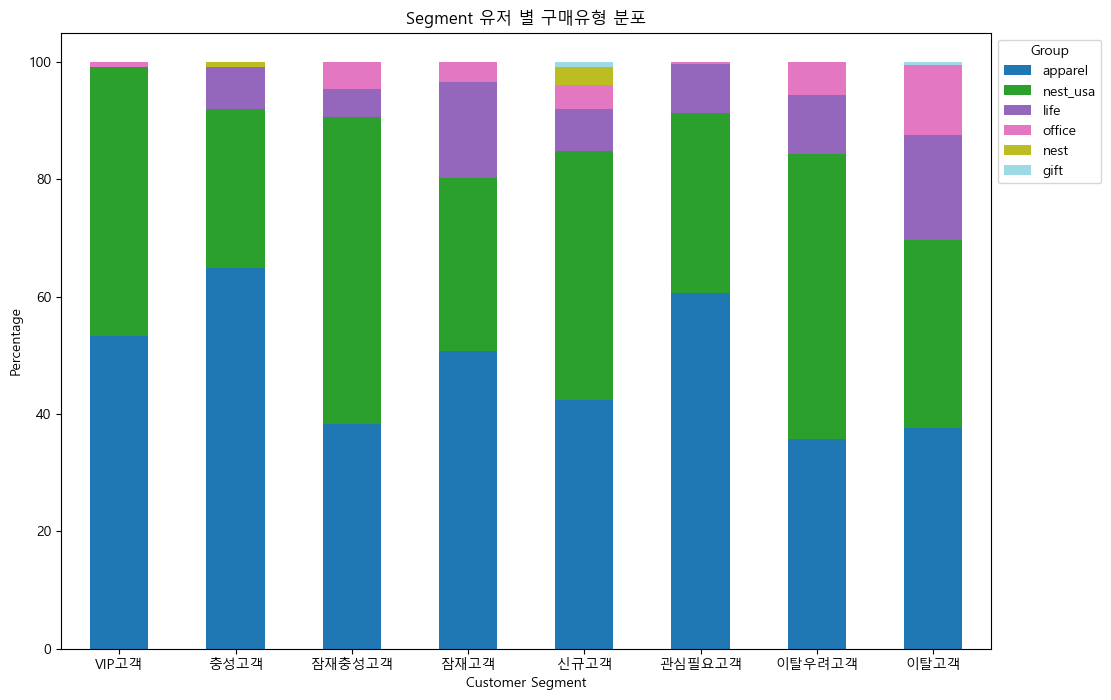

In [96]:
def stacked_bar(tmp_result):
    totals = tmp_result.sum(axis = 1)
    percent_df = tmp_result.div(totals, axis = 0)* 100
    
    order = ['VIP고객', '충성고객', '잠재충성고객', '잠재고객', '신규고객', '관심필요고객', '이탈우려고객', '이탈고객']
    percent_df = percent_df.reindex(order)
    
    percent_df = percent_df[['apparel', 'nest_usa', 'life', 'office', 'nest', 'gift']]
    percent_df.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
    
    plt.title('Segment 유저 별 구매유형 분포')
    plt.xlabel('Customer Segment')
    plt.xticks(rotation = 0)
    plt.ylabel('Percentage')
    plt.legend(title='Group', bbox_to_anchor=(1.0, 1), loc='upper left')
    plt.show()
    
stacked_bar(tmp_result)

## 7. Conclusion
  
분석결과,  
해당 이커머스서비스의 경우 Nest-USA와 Apparel이 사업의 핵심 제품군이기 때문에 해당 제품거래에 있어서 각종 혜택 및 서비스 제공에 하자가 없어야 할 것이다.  
잠재고객, 이탈고객의 경우 life, office 제품군의 비율이 높아짐을 볼 수 있다. 이를 통해 두가지를 추가로 확인하여 이탈의 원인을 추적해볼 수 있다.   
 1. life, office 제품들 혹은 거래 및 서비스 과정에 문제가 있었는지?  
 2. 이탈고객들이 Nest 및 Apparel제품에 흥미를 못느끼고 가벼운 제품만 구입하다 나가는 것인지?  
  
신규고객의 경우 구매 카테고리의 스펙트럼이 다양한 편이다. 즉, 신규고객은 기존 사이트의 강점이라할 수 있는 Apparel과 Nest-USA에 흥미를 느끼는 것도 당연하지만, 다양한 상품군에 흥미를 끌 수 있도록하는 전략도 유용할 수 있다.  